In [1]:
import time
import datetime 
from datetime import date
import pandas as pd
import numpy as np
import sys
import sqlalchemy
import pyodbc
from sqlalchemy import create_engine
import requests, json 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 160)

In [341]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics as mt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from itertools import cycle

In [318]:
import shap
import xgboost
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix, auc
from dmba import classificationSummary
from sklearn import preprocessing
sns.set()
pd.set_option('display.max_columns', 160)
pd.set_option('display.max_rows', 160)

In [4]:
#setup driver
driver='ODBC Driver 17 for SQL Server'
servername='184.105.4.175:1433'
database='power_outage_data'
username='justinwang@mail.smu.edu' 
password='power_outage_smu123' 
engine=sqlalchemy.create_engine('mssql+pyodbc://'+username+":"+password+"@"+servername+'/'+database+'?driver=' + driver, fast_executemany=True)

In [5]:
#read from SQL
sql= '''select 
  [Weekday]
  ,d.IsWeekend
  ,d.[Month]
  ,datepart(hh,RecordDateTime_CST) as [hour]
  ,k.* FROM [power_outage_data].[dbo].[historic_weather_data_PIVOTED_with_ALL_FEATURES] k
  left join [power_outage_data].[dbo].[dimdate_dst_table] d on cast(k.RecordDateTime_CST as date) = cast(d.[Date] as date)'''

data = pd.read_sql(sql,engine)
data

,Weekday,IsWeekend,Month,hour,Metro_Area,RecordDateTime_CST,RecordDateTime_UTC,State,County,RecordDateTime_EST,Customer_Count,Outage_Count,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,Clear_sky is clear,Clouds_broken clouds,Clouds_few clouds,Clouds_overcast clouds,Clouds_scattered clouds,Drizzle_drizzle,Drizzle_heavy intensity drizzle,Drizzle_light intensity drizzle,Dust_dust,Fog_fog,Haze_haze,Mist_mist,Rain_extreme rain,Rain_freezing rain,Rain_heavy intensity rain,Rain_heavy intesity shower rain,Rain_light rain,Rain_moderate rain,Rain_proximity shower rain,Rain_shower rain,Rain_very heavy rain,Smoke_smoke,Snow_heavy snow,Snow_light rain and snow,Snow_light snow,Snow_snow,Squall_squalls,Thunderstorm_proximity thunderstorm,Thunderstorm_proximity thunderstorm with rain,Thunderstorm_ragged thunderstorm,Thunderstorm_thunderstorm,Thunderstorm_thunderstorm with heavy rain,Thunderstorm_thunderstorm with light rain,Thunderstorm_thunderstorm with rain,ERCOT_WEATHERZONE_LOAD,ERCOT_RT_LOADZONE_PRICE,ERCOT_RT_HUB_PRICE,ERCOT_DA_LOADZONE_PRICE,ERCOT_DA_HUB_PRICE
0,5,False,12,14,Houston,2019-12-26 14:00:00,2019-12-26 20:00:00,Texas,Brazoria,2019-12-26 15:00:00,123921,3,73.83,73.92,71.94,79.05,1017,None,None,64,6.93,0,NaN,NaN,NaN,NaN,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"10,995.12",19.1675,19.1675,17.92,17.90
1,6,False,12,21,Houston,2019-12-27 21:00:00,2019-12-28 03:00:00,Texas,Brazoria,2019-12-27 22:00:00,123921,0,63.93,63.18,62.01,65.25,1016,None,None,67,5.82,70,NaN,NaN,NaN,NaN,90,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"10,742.25",11.7950,11.7300,14.04,14.00
2,6,False,12,22,Houston,2019-12-27 22:00:00,2019-12-28 04:00:00,Texas,Brazoria,2019-12-27 23:00:00,123921,0,63.93,63.23,61.99,65.05,1015,None,None,68,6.93,90,NaN,NaN,NaN,NaN,90,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"10,482.28",7.1850,7.1625,15.17,15.17
3,1,True,10,8,Houston,2017-10-15 08:00:00,2017-10-15 13:00:00,Texas,Brazoria,2017-10-15 09:00:00,105618,0,70.02,71.10,68.05,74.01,1017,None,None,93,3.36,360,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10290.98948,16.7025,16.7025,20.16,19.94
4,1,True,10,11,Houston,2017-10-15 11:00:00,2017-10-15 16:00:00,Texas,Brazoria,2017-10-15 12:00:00,105618,0,84.54,90.97,83.98,86.20,1020,None,None,68,11.41,10,NaN,NaN,NaN,NaN,20,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12725.09045,20.8900,20.9150,27.30,26.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317019,3,False,3,22,Dallas,2021-03-16 22:00:00,2021-03-17 03:00:00,Texas,Denton,2021-03-16 23:00:00,341985,6,71.74,72.10,68.58,73.69,1001,None,None,74,1.99,219,NaN,NaN,NaN,NaN,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"12,954.02",13.1575,13.2975,21.80,21.20
317020,5,False,10,7,Dallas,2020-10-01 07:00:00,2020-10-01 12:00:00,Texas,Denton,2020-10-01 08:00:00,296515,0,62.44,61.43,58.78,65.10,1016,None,None,65,0.00,0,NaN,NaN,NaN,NaN,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10082.98589,15.4900,15.4875,12.46,12.44
317021,2,False,2,21,Dallas,2021-02-08 21:00:00,2021-02-09 03:00:00,Texas,Dallas,2021-02-08 22:00:00,1083529,53,44.20,37.24,41.45,47.66,1016,None,None,80,14.97,320,NaN,NaN,NaN,NaN,90,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"12,798.99",20.7675,20.7675,25.39,25.32
317022,4,False,2,21,Dallas,2021-02-10 21:00:00,2021-02-11 03:00:00,Texas,Denton,2021-02-10 22:00:00,297886,8,27.61,27.61,26.56,29.17,1019,None,None,89,1.01,59,NaN,NaN,NaN,NaN,90,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"19,836.55",48.1075,48.0675,33.92,33.56


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317024 entries, 0 to 317023
Data columns (total 66 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   Weekday                                        317024 non-null  int64         
 1   IsWeekend                                      317024 non-null  bool          
 2   Month                                          317024 non-null  int64         
 3   hour                                           317024 non-null  int64         
 4   Metro_Area                                     317024 non-null  object        
 5   RecordDateTime_CST                             317024 non-null  datetime64[ns]
 6   RecordDateTime_UTC                             317024 non-null  datetime64[ns]
 7   State                                          317024 non-null  object        
 8   County                                      

In [7]:
data['outage_percent'] = data['Outage_Count']/data['Customer_Count']
data.head()

,Weekday,IsWeekend,Month,hour,Metro_Area,RecordDateTime_CST,RecordDateTime_UTC,State,County,RecordDateTime_EST,Customer_Count,Outage_Count,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,Clear_sky is clear,Clouds_broken clouds,Clouds_few clouds,Clouds_overcast clouds,Clouds_scattered clouds,Drizzle_drizzle,Drizzle_heavy intensity drizzle,Drizzle_light intensity drizzle,Dust_dust,Fog_fog,Haze_haze,Mist_mist,Rain_extreme rain,Rain_freezing rain,Rain_heavy intensity rain,Rain_heavy intesity shower rain,Rain_light rain,Rain_moderate rain,Rain_proximity shower rain,Rain_shower rain,Rain_very heavy rain,Smoke_smoke,Snow_heavy snow,Snow_light rain and snow,Snow_light snow,Snow_snow,Squall_squalls,Thunderstorm_proximity thunderstorm,Thunderstorm_proximity thunderstorm with rain,Thunderstorm_ragged thunderstorm,Thunderstorm_thunderstorm,Thunderstorm_thunderstorm with heavy rain,Thunderstorm_thunderstorm with light rain,Thunderstorm_thunderstorm with rain,ERCOT_WEATHERZONE_LOAD,ERCOT_RT_LOADZONE_PRICE,ERCOT_RT_HUB_PRICE,ERCOT_DA_LOADZONE_PRICE,ERCOT_DA_HUB_PRICE,outage_percent
0,5,False,12,14,Houston,2019-12-26 14:00:00,2019-12-26 20:00:00,Texas,Brazoria,2019-12-26 15:00:00,123921,3,73.83,73.92,71.94,79.05,1017,None,None,64,6.93,0,NaN,NaN,NaN,NaN,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"10,995.12",19.1675,19.1675,17.92,17.90,0.000024
1,6,False,12,21,Houston,2019-12-27 21:00:00,2019-12-28 03:00:00,Texas,Brazoria,2019-12-27 22:00:00,123921,0,63.93,63.18,62.01,65.25,1016,None,None,67,5.82,70,NaN,NaN,NaN,NaN,90,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"10,742.25",11.7950,11.7300,14.04,14.00,0.000000
2,6,False,12,22,Houston,2019-12-27 22:00:00,2019-12-28 04:00:00,Texas,Brazoria,2019-12-27 23:00:00,123921,0,63.93,63.23,61.99,65.05,1015,None,None,68,6.93,90,NaN,NaN,NaN,NaN,90,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"10,482.28",7.1850,7.1625,15.17,15.17,0.000000
3,1,True,10,8,Houston,2017-10-15 08:00:00,2017-10-15 13:00:00,Texas,Brazoria,2017-10-15 09:00:00,105618,0,70.02,71.10,68.05,74.01,1017,None,None,93,3.36,360,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10290.98948,16.7025,16.7025,20.16,19.94,0.000000
4,1,True,10,11,Houston,2017-10-15 11:00:00,2017-10-15 16:00:00,Texas,Brazoria,2017-10-15 12:00:00,105618,0,84.54,90.97,83.98,86.20,1020,None,None,68,11.41,10,NaN,NaN,NaN,NaN,20,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12725.09045,20.8900,20.9150,27.30,26.86,0.000000


In [8]:
data.shape

(317024, 67)

In [9]:
data.isna().mean()

Weekday                                          0.000000
IsWeekend                                        0.000000
Month                                            0.000000
hour                                             0.000000
Metro_Area                                       0.000000
RecordDateTime_CST                               0.000000
RecordDateTime_UTC                               0.000000
State                                            0.000000
County                                           0.000000
RecordDateTime_EST                               0.000000
Customer_Count                                   0.000000
Outage_Count                                     0.000000
temp                                             0.000000
feels_like                                       0.000000
temp_min                                         0.000000
temp_max                                         0.000000
pressure                                         0.000000
sea_level     

In [10]:
# Delete sea_level, grnd_level, rain_1h, rain_3h, snow_1h and and snow_3h.''
missing_col = ['sea_level', 'grnd_level', 'rain_1h','rain_3h', 'snow_1h','snow_3h']
data = data.drop(missing_col, axis=1)

In [11]:
#change the ERCOT_WEATHERZONE_LOAD to numeric
data['ERCOT_WEATHERZONE_LOAD'] = pd.to_numeric(data['ERCOT_WEATHERZONE_LOAD'],errors='coerce')

In [12]:
#Impute missing values with medium
data = data.fillna(data.median())

In [13]:
data.isna().mean()
#The data doesn't contain any missing values.

Weekday                                          0.0
IsWeekend                                        0.0
Month                                            0.0
hour                                             0.0
Metro_Area                                       0.0
RecordDateTime_CST                               0.0
RecordDateTime_UTC                               0.0
State                                            0.0
County                                           0.0
RecordDateTime_EST                               0.0
Customer_Count                                   0.0
Outage_Count                                     0.0
temp                                             0.0
feels_like                                       0.0
temp_min                                         0.0
temp_max                                         0.0
pressure                                         0.0
humidity                                         0.0
wind_speed                                    

In [14]:
data.columns = data.columns.str.replace(' ', '_')
data.columns

Index(['Weekday', 'IsWeekend', 'Month', 'hour', 'Metro_Area',
       'RecordDateTime_CST', 'RecordDateTime_UTC', 'State', 'County',
       'RecordDateTime_EST', 'Customer_Count', 'Outage_Count', 'temp',
       'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'clouds_all', 'Clear_sky_is_clear',
       'Clouds_broken_clouds', 'Clouds_few_clouds', 'Clouds_overcast_clouds',
       'Clouds_scattered_clouds', 'Drizzle_drizzle',
       'Drizzle_heavy_intensity_drizzle', 'Drizzle_light_intensity_drizzle',
       'Dust_dust', 'Fog_fog', 'Haze_haze', 'Mist_mist', 'Rain_extreme_rain',
       'Rain_freezing_rain', 'Rain_heavy_intensity_rain',
       'Rain_heavy_intesity_shower_rain', 'Rain_light_rain',
       'Rain_moderate_rain', 'Rain_proximity_shower_rain', 'Rain_shower_rain',
       'Rain_very_heavy_rain', 'Smoke_smoke', 'Snow_heavy_snow',
       'Snow_light_rain_and_snow', 'Snow_light_snow', 'Snow_snow',
       'Squall_squalls', 'Thunderstorm_prox

In [15]:
data['RecordDateTime_CST'] = pd.to_datetime(data['RecordDateTime_CST']).dt.date

<AxesSubplot:xlabel='RecordDateTime_CST', ylabel='temp'>

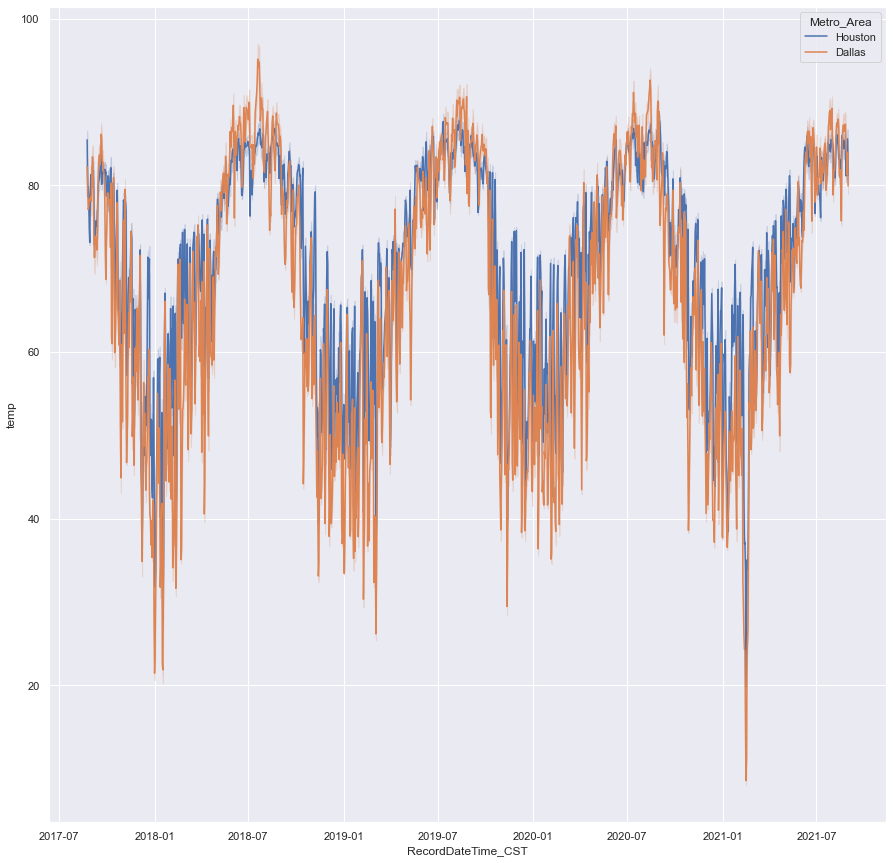

In [16]:
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(15,15)})

sns.lineplot(x="RecordDateTime_CST", y="temp",hue="Metro_Area", data=data)

<AxesSubplot:xlabel='RecordDateTime_CST', ylabel='Outage_Count'>

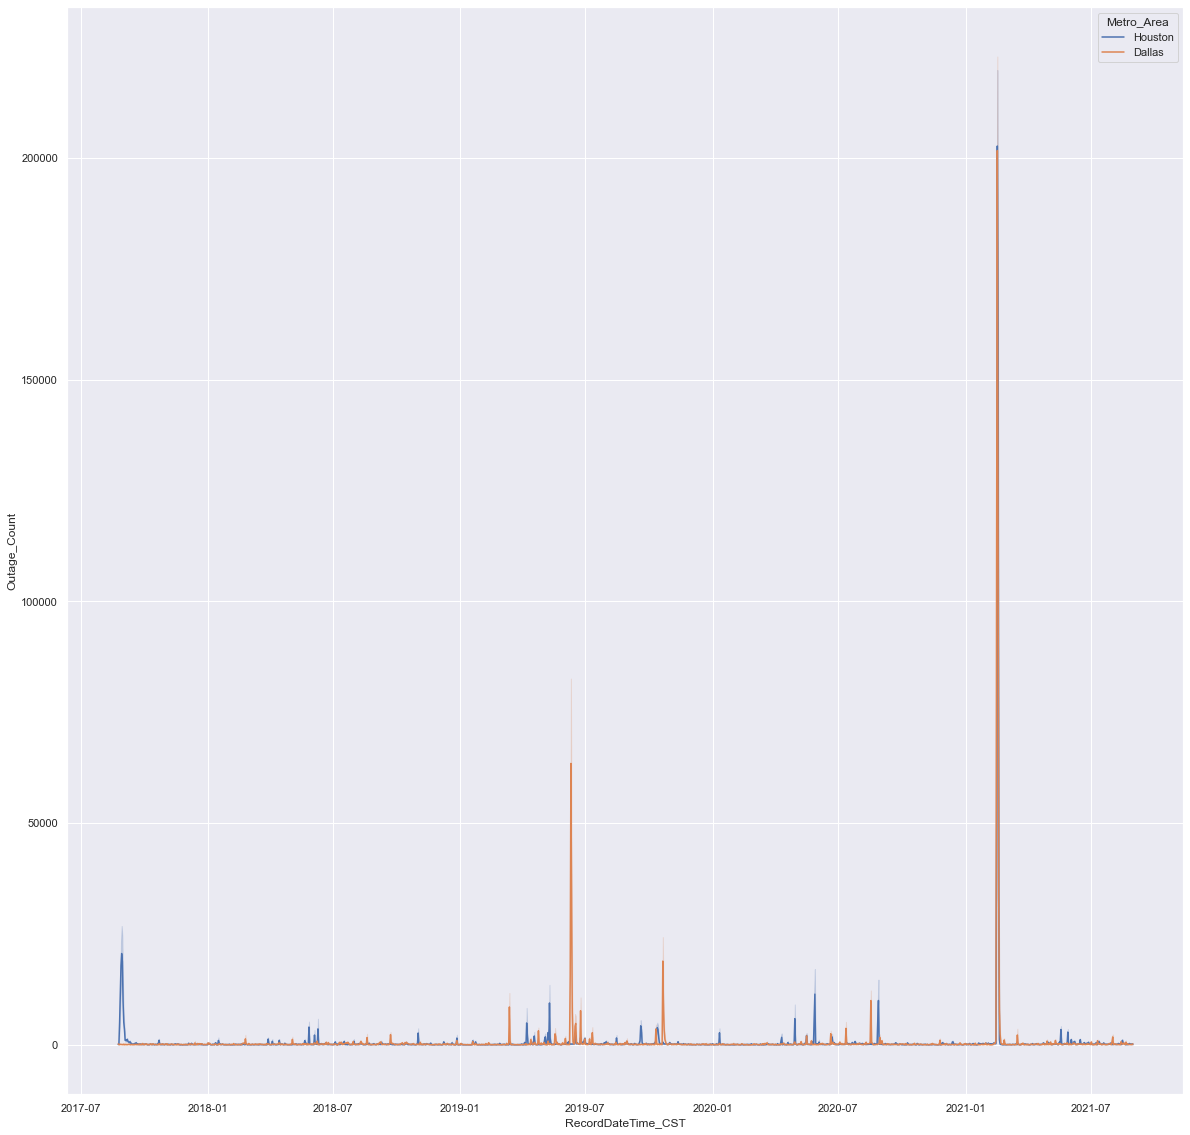

In [17]:
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,20)})

sns.lineplot(x="RecordDateTime_CST", y="Outage_Count",hue="Metro_Area", data=data)

<AxesSubplot:xlabel='RecordDateTime_CST', ylabel='ERCOT_WEATHERZONE_LOAD'>

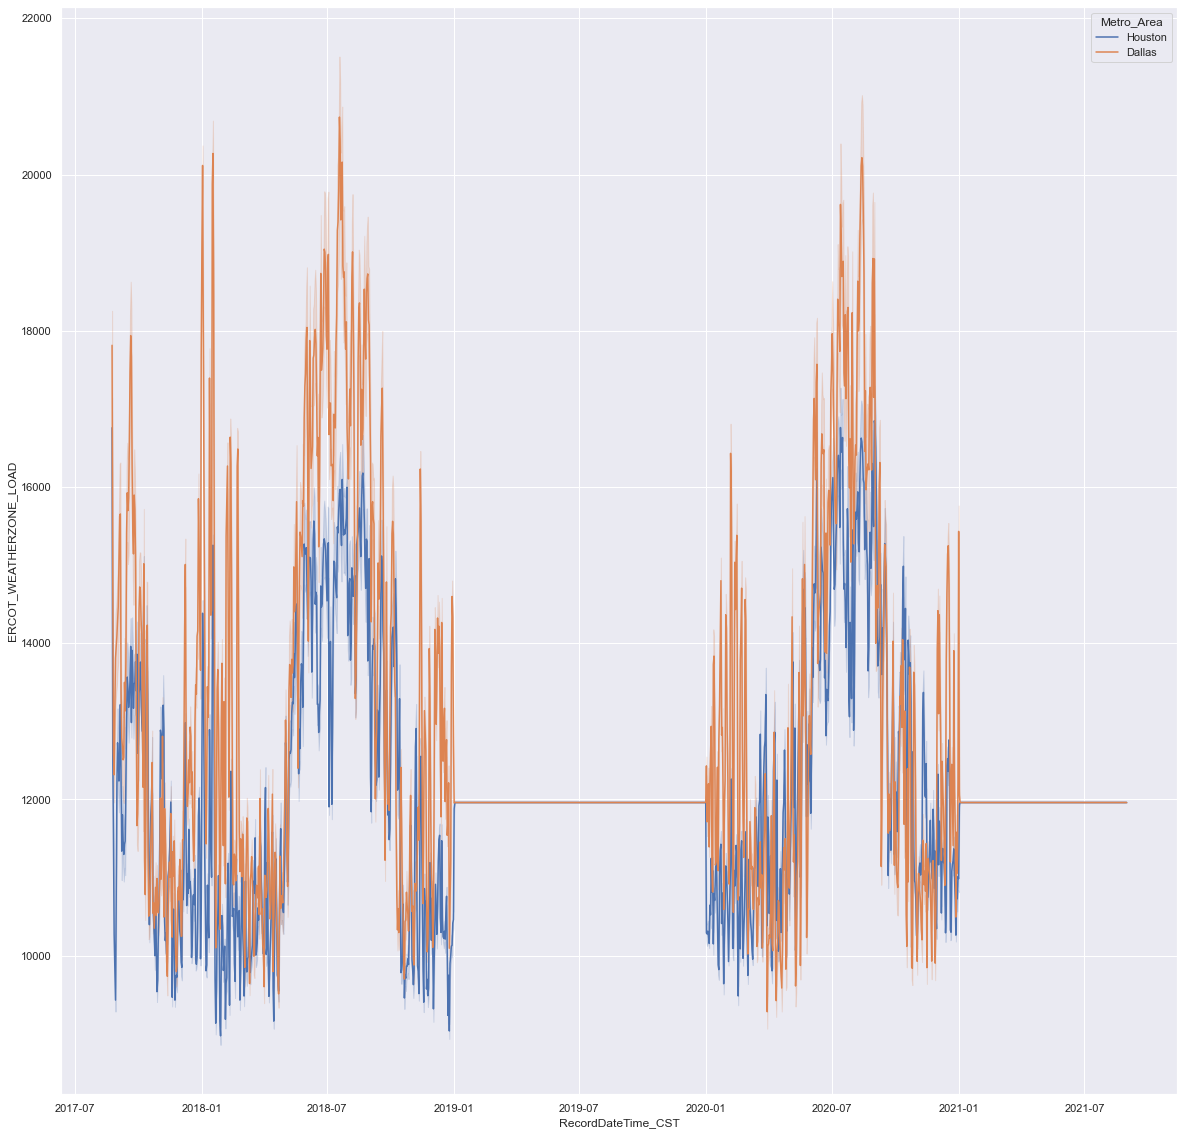

In [18]:
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,20)})

sns.lineplot(x="RecordDateTime_CST", y="ERCOT_WEATHERZONE_LOAD",hue="Metro_Area", data=data)

<AxesSubplot:xlabel='RecordDateTime_CST', ylabel='ERCOT_RT_LOADZONE_PRICE'>

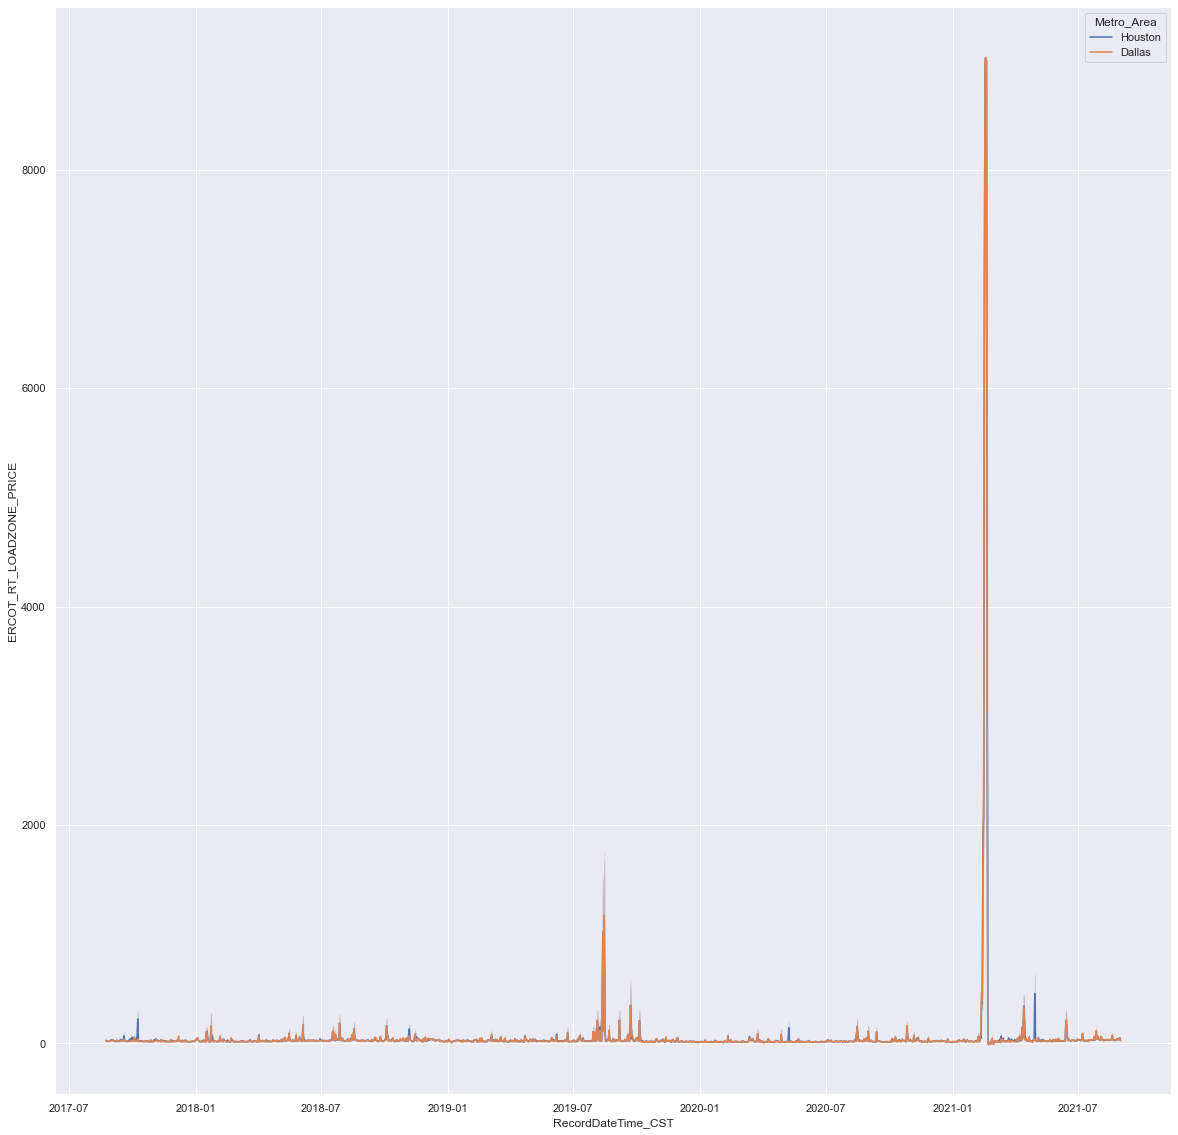

In [19]:
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,20)})

sns.lineplot(x="RecordDateTime_CST", y='ERCOT_RT_LOADZONE_PRICE',hue="Metro_Area", data=data)

<AxesSubplot:xlabel='RecordDateTime_CST', ylabel='ERCOT_RT_HUB_PRICE'>

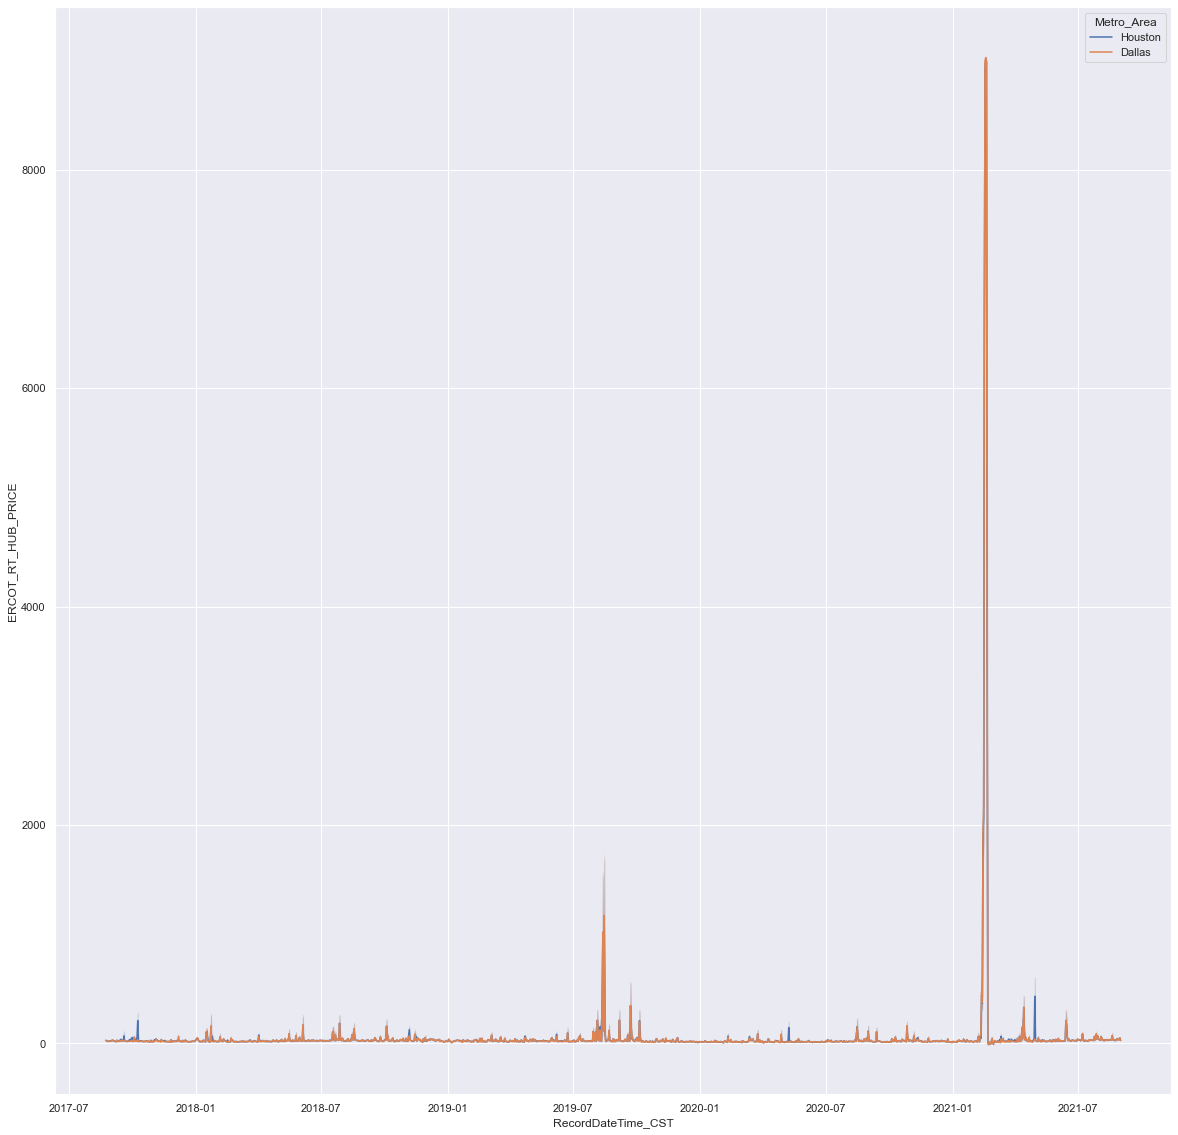

In [20]:
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,20)})

sns.lineplot(x="RecordDateTime_CST", y='ERCOT_RT_HUB_PRICE',hue="Metro_Area", data=data)

<AxesSubplot:xlabel='RecordDateTime_CST', ylabel='ERCOT_DA_LOADZONE_PRICE'>

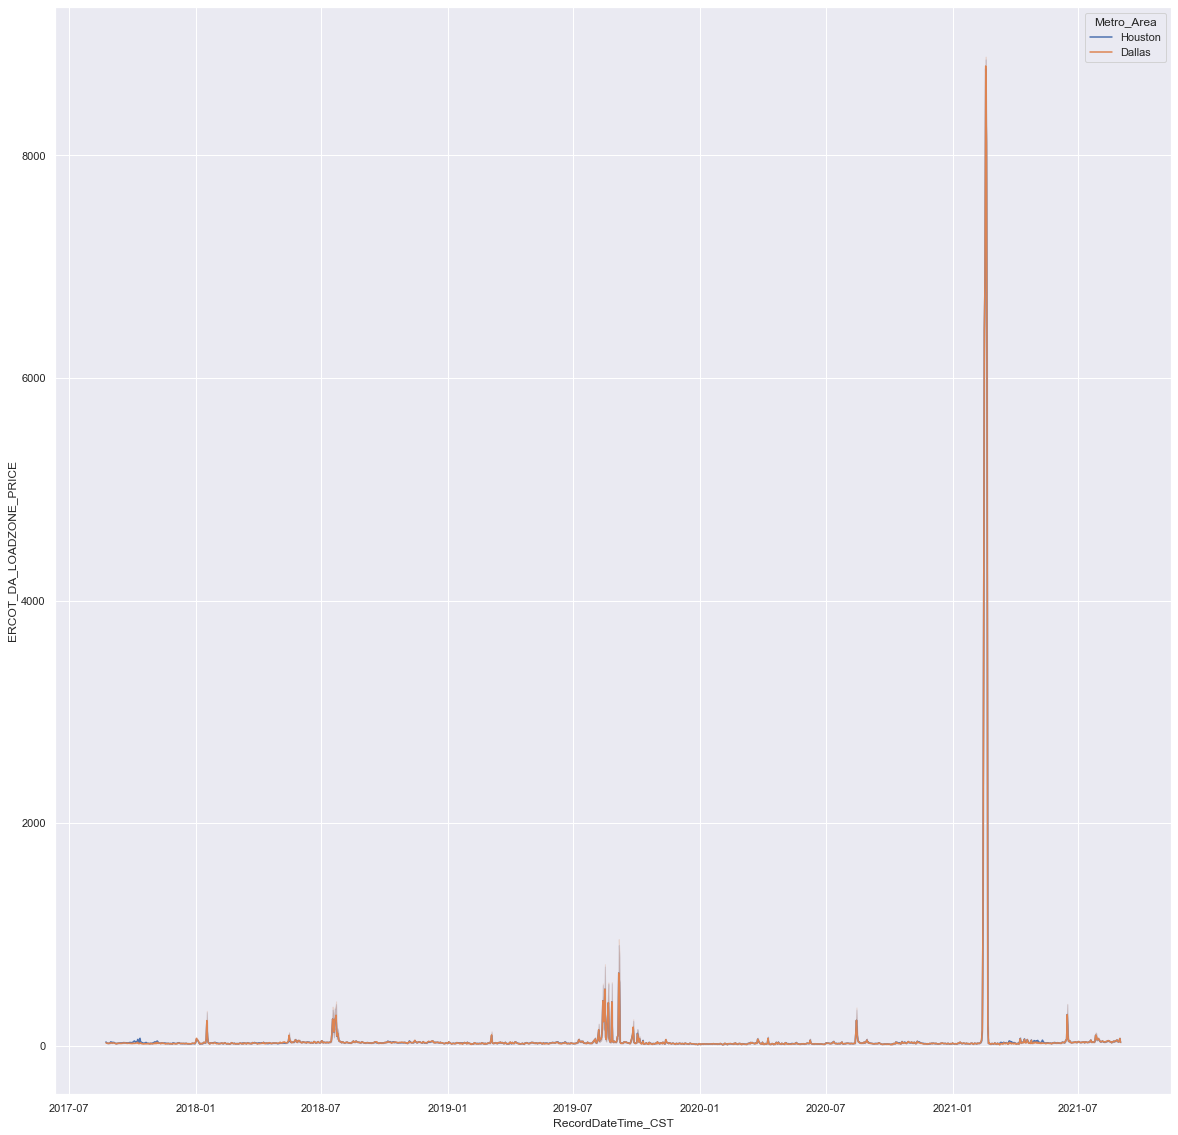

In [21]:
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,20)})

sns.lineplot(x="RecordDateTime_CST", y='ERCOT_DA_LOADZONE_PRICE',hue="Metro_Area", data=data)

<AxesSubplot:xlabel='RecordDateTime_CST', ylabel='ERCOT_DA_HUB_PRICE'>

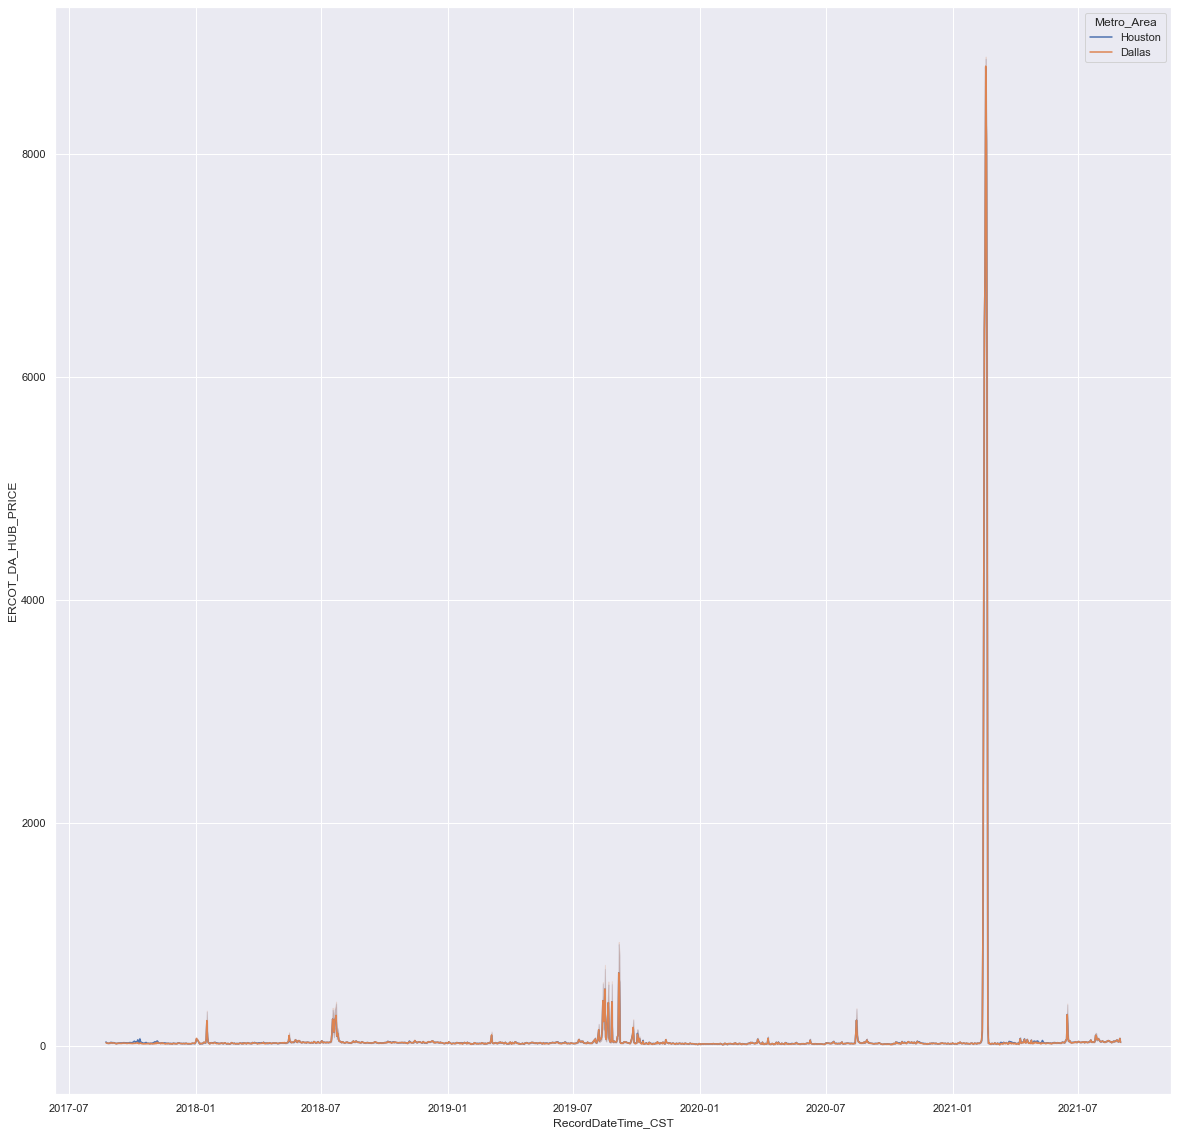

In [22]:
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,20)})

sns.lineplot(x="RecordDateTime_CST", y='ERCOT_DA_HUB_PRICE',hue="Metro_Area", data=data)

In [23]:
data.pivot_table(index=['Metro_Area','Snow_snow'], values='Outage_Count',aggfunc='mean').round(1)

Outage_Count
Metro_Area Snow_snow              
Dallas     0                 606.8
           1               32878.9
Houston    0                 596.0
           1               31599.5

In [24]:
data.pivot_table(index=['Metro_Area','Rain_freezing_rain'], values='Outage_Count',aggfunc='mean').round(1)

Outage_Count
Metro_Area Rain_freezing_rain              
Dallas     0                          628.8
           1                           26.4
Houston    0                          611.7
           1                        77524.0

<AxesSubplot:xlabel='RecordDateTime_CST', ylabel='Outage_Count'>

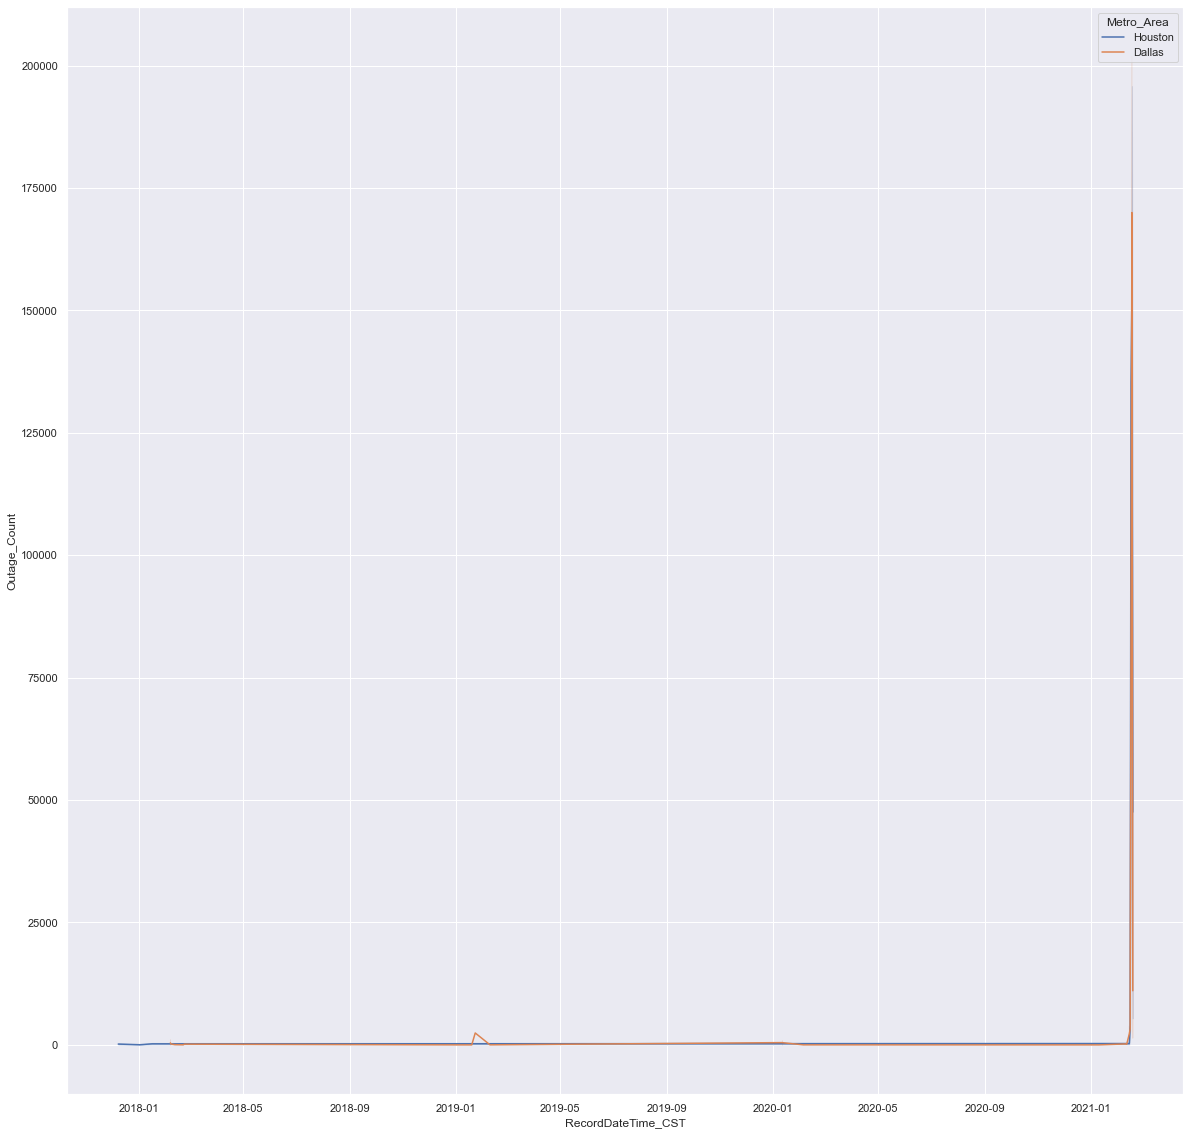

In [25]:
data_snow = data.loc[data['Snow_snow']==1]
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,20)})

sns.lineplot(x="RecordDateTime_CST", y="Outage_Count",hue='Metro_Area', data=data_snow)

<AxesSubplot:xlabel='RecordDateTime_CST', ylabel='Customer_Count'>

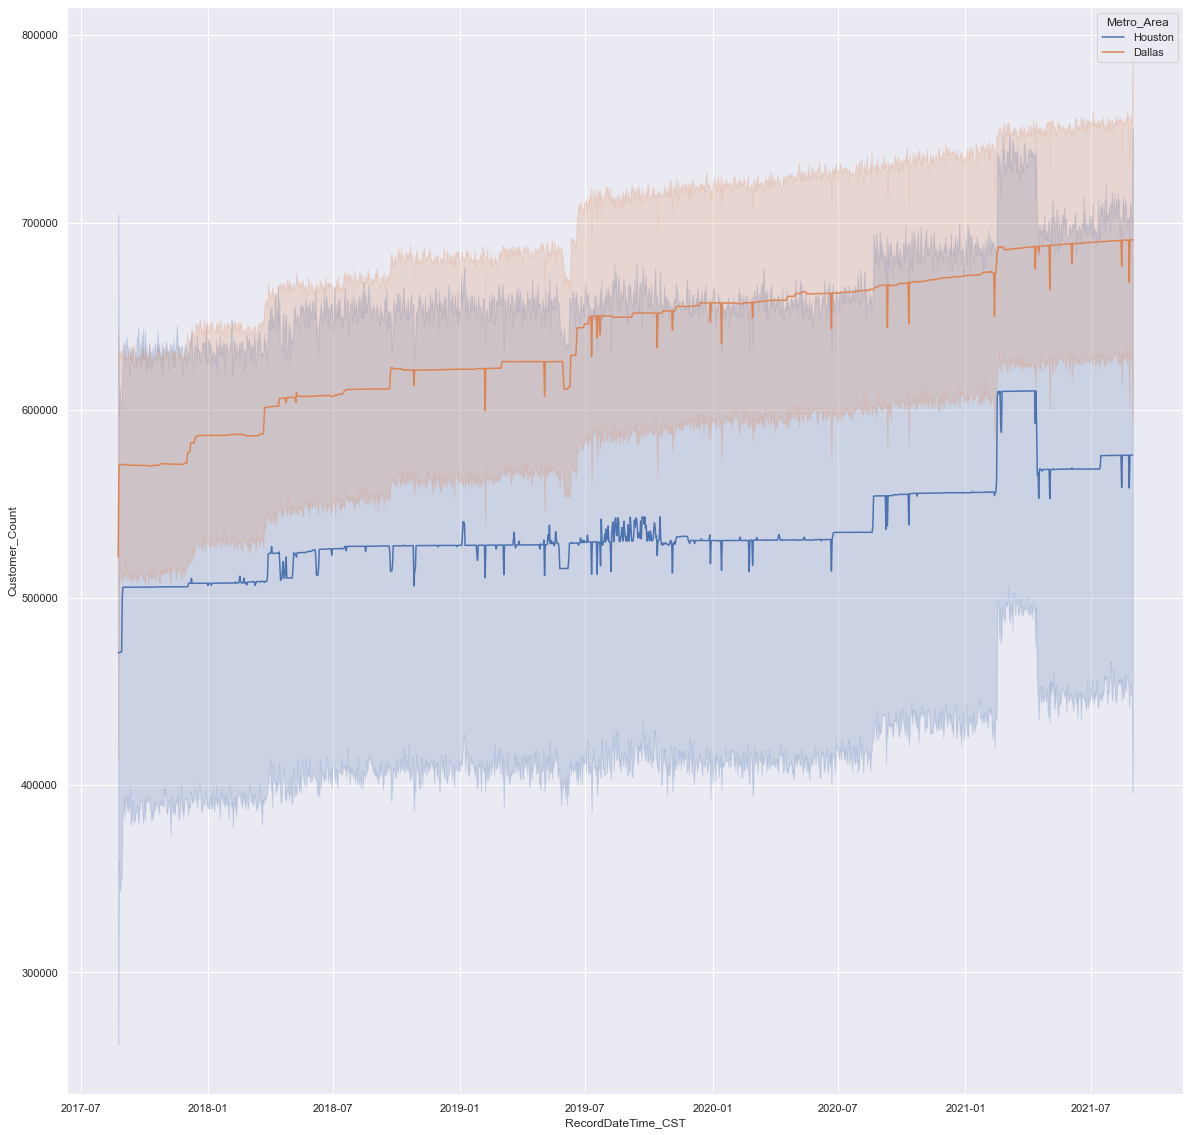

In [26]:
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,20)})

sns.lineplot(x="RecordDateTime_CST", y="Customer_Count",hue='Metro_Area', data=data)

In [27]:
data_continuous = data.drop(['Metro_Area', 'RecordDateTime_CST', 'RecordDateTime_UTC', 'State', 
                             'County','RecordDateTime_EST'], axis=1)

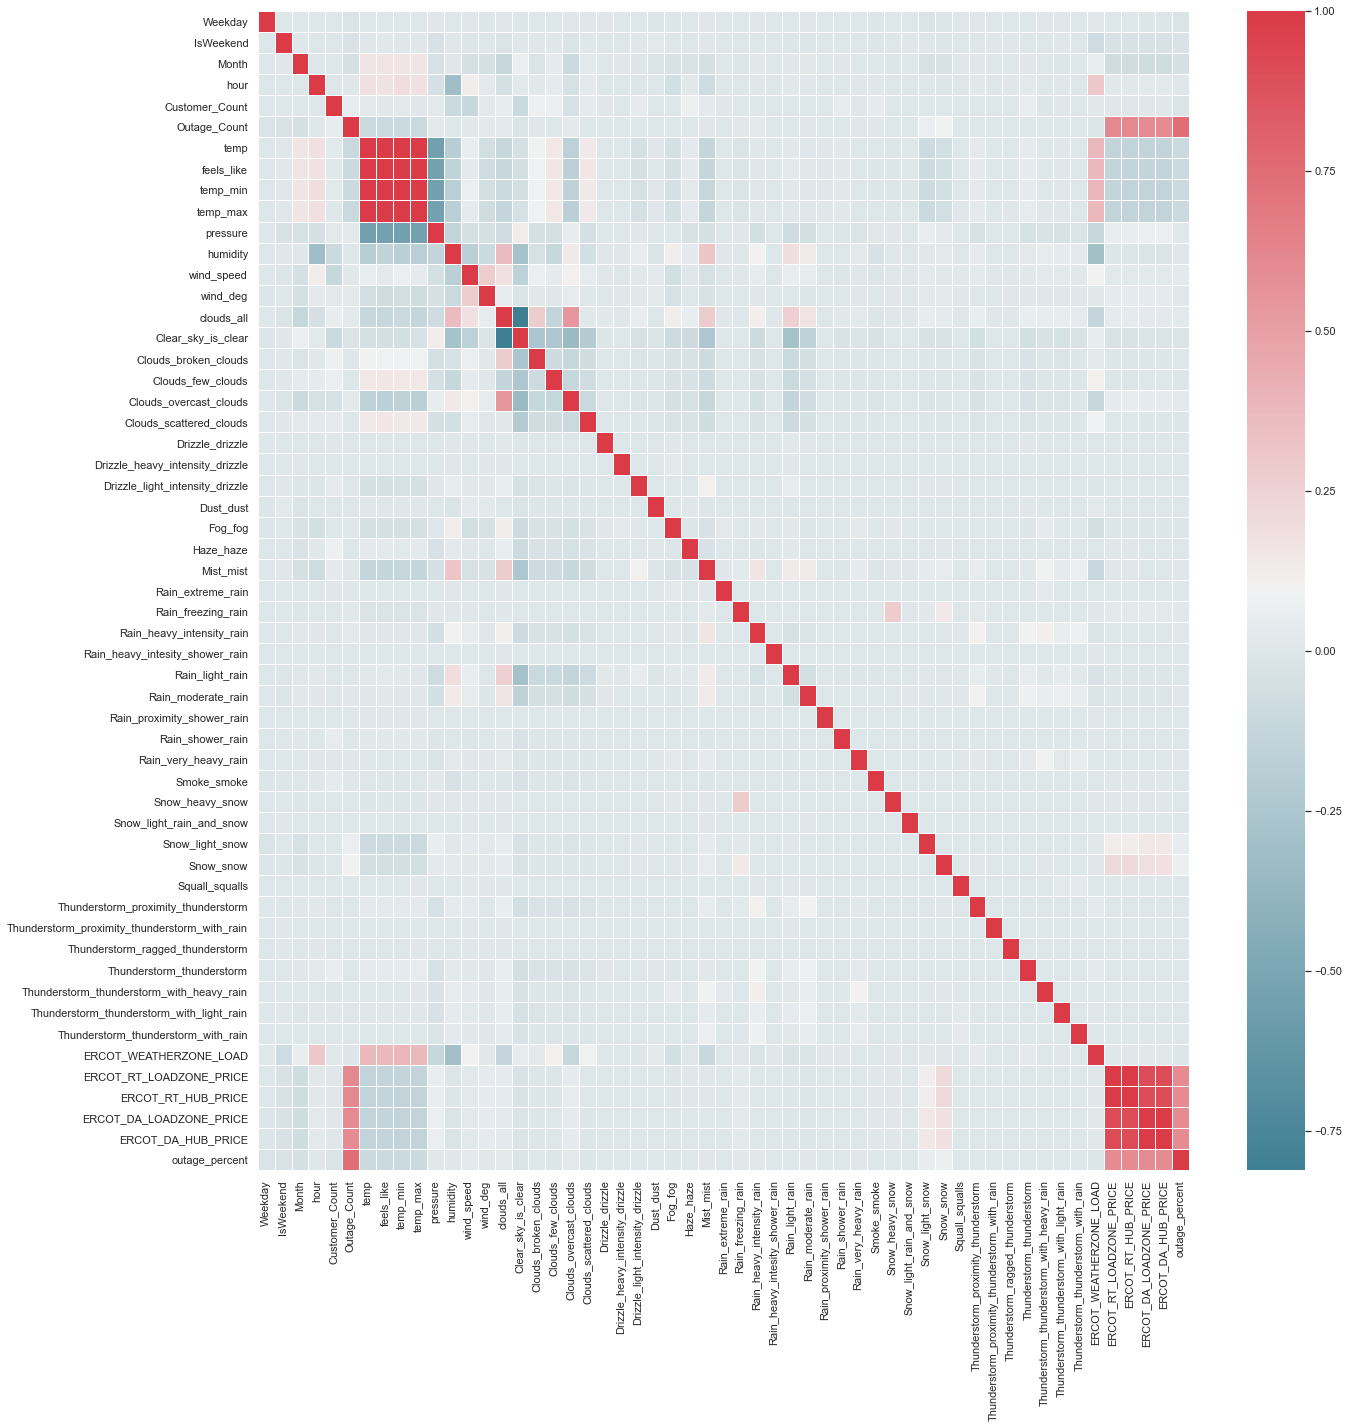

In [28]:
sns.set(style='darkgrid')
cmap = sns.diverging_palette(220, 10,as_cmap=True)
f, ax= plt.subplots(figsize=(20,20))

sns.heatmap(data_continuous.corr(),cmap=cmap,annot=False,fmt='.3f',linewidth=.5,ax=ax)
f.tight_layout()

In [29]:
data_new = data[(data['outage_percent']>=.01) & (data['outage_percent']<=1)]

[Text(0, 0, 'Brazoria'),
 Text(1, 0, 'Denton'),
 Text(2, 0, 'Dallas'),
 Text(3, 0, 'Fort Bend'),
 Text(4, 0, 'Collin'),
 Text(5, 0, 'Galveston'),
 Text(6, 0, 'Harris'),
 Text(7, 0, 'Montgomery'),
 Text(8, 0, 'Tarrant')]

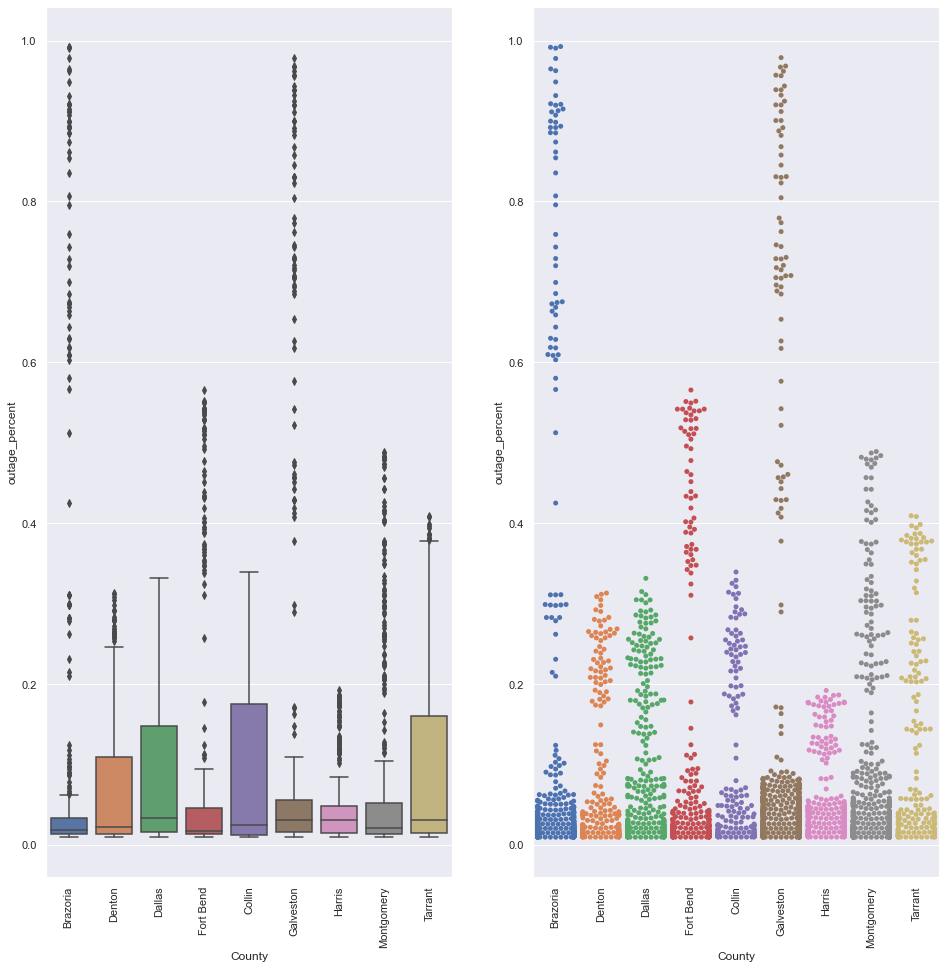

In [30]:
fig, axes = plt.subplots(1,2, figsize=(16,16))

ax = sns.boxplot(x="County", y="outage_percent", data=data_new, ax=axes[0])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax = sns.swarmplot(x="County", y="outage_percent", data=data_new, ax=axes[1])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
#ax = sns.violinplot(x="County", y="outage_percent", data=data_new, ax=axes[2])
#ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [31]:
 data_new[data['outage_percent']>=1]

,Weekday,IsWeekend,Month,hour,Metro_Area,RecordDateTime_CST,RecordDateTime_UTC,State,County,RecordDateTime_EST,Customer_Count,Outage_Count,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,Clear_sky_is_clear,Clouds_broken_clouds,Clouds_few_clouds,Clouds_overcast_clouds,Clouds_scattered_clouds,Drizzle_drizzle,Drizzle_heavy_intensity_drizzle,Drizzle_light_intensity_drizzle,Dust_dust,Fog_fog,Haze_haze,Mist_mist,Rain_extreme_rain,Rain_freezing_rain,Rain_heavy_intensity_rain,Rain_heavy_intesity_shower_rain,Rain_light_rain,Rain_moderate_rain,Rain_proximity_shower_rain,Rain_shower_rain,Rain_very_heavy_rain,Smoke_smoke,Snow_heavy_snow,Snow_light_rain_and_snow,Snow_light_snow,Snow_snow,Squall_squalls,Thunderstorm_proximity_thunderstorm,Thunderstorm_proximity_thunderstorm_with_rain,Thunderstorm_ragged_thunderstorm,Thunderstorm_thunderstorm,Thunderstorm_thunderstorm_with_heavy_rain,Thunderstorm_thunderstorm_with_light_rain,Thunderstorm_thunderstorm_with_rain,ERCOT_WEATHERZONE_LOAD,ERCOT_RT_LOADZONE_PRICE,ERCOT_RT_HUB_PRICE,ERCOT_DA_LOADZONE_PRICE,ERCOT_DA_HUB_PRICE,outage_percent


In [32]:
#Check all the counties by their sum of outage counts
data.groupby('County').agg({'Outage_Count':'sum'})

,Outage_Count
County,
Brazoria,19063018
Collin,10188314
Dallas,40820030
Denton,7651042
Fort Bend,12199527
Galveston,11474154
Harris,50570035
Montgomery,14571601
Tarrant,29941602


In [33]:
data = data.drop(['RecordDateTime_UTC','RecordDateTime_EST','RecordDateTime_CST','State','Metro_Area','IsWeekend'], axis=1)

In [34]:
data['Weekday'] = data['Weekday'].astype('category')
data['Month'] = data['Month'].astype('category')
data['hour'] = data['hour'].astype('category')

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317024 entries, 0 to 317023
Data columns (total 55 columns):
 #   Column                                         Non-Null Count   Dtype   
---  ------                                         --------------   -----   
 0   Weekday                                        317024 non-null  category
 1   Month                                          317024 non-null  category
 2   hour                                           317024 non-null  category
 3   County                                         317024 non-null  object  
 4   Customer_Count                                 317024 non-null  int64   
 5   Outage_Count                                   317024 non-null  int64   
 6   temp                                           317024 non-null  float64 
 7   feels_like                                     317024 non-null  float64 
 8   temp_min                                       317024 non-null  float64 
 9   temp_max                  

In [161]:
data[data['outage_percent']>1]

,Weekday,Month,hour,County,Customer_Count,Outage_Count,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,Clear_sky_is_clear,Clouds_broken_clouds,Clouds_few_clouds,Clouds_overcast_clouds,Clouds_scattered_clouds,Drizzle_drizzle,Drizzle_heavy_intensity_drizzle,Drizzle_light_intensity_drizzle,Dust_dust,Fog_fog,Haze_haze,Mist_mist,Rain_extreme_rain,Rain_freezing_rain,Rain_heavy_intensity_rain,Rain_heavy_intesity_shower_rain,Rain_light_rain,Rain_moderate_rain,Rain_proximity_shower_rain,Rain_shower_rain,Rain_very_heavy_rain,Smoke_smoke,Snow_heavy_snow,Snow_light_rain_and_snow,Snow_light_snow,Snow_snow,Squall_squalls,Thunderstorm_proximity_thunderstorm,Thunderstorm_proximity_thunderstorm_with_rain,Thunderstorm_ragged_thunderstorm,Thunderstorm_thunderstorm,Thunderstorm_thunderstorm_with_heavy_rain,Thunderstorm_thunderstorm_with_light_rain,Thunderstorm_thunderstorm_with_rain,ERCOT_WEATHERZONE_LOAD,ERCOT_RT_LOADZONE_PRICE,ERCOT_RT_HUB_PRICE,ERCOT_DA_LOADZONE_PRICE,ERCOT_DA_HUB_PRICE,outage_percent
114073,2,2,21,Galveston,119619,132140,21.81,9.21,19.06,23.02,1024,68,17.22,350,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11961.99645,4804.7025,4805.4050,7188.35,7188.62,1.104674
225274,2,2,20,Brazoria,142256,237678,19.98,9.36,19.02,21.27,1024,67,9.17,330,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11961.99645,6970.3050,6965.6275,7890.98,7891.45,1.670777
281298,2,2,21,Brazoria,142257,282911,19.89,9.25,19.38,21.25,1026,67,9.17,340,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11961.99645,4804.7025,4805.4050,7188.35,7188.62,1.988732


In [162]:
#Drop outage percentage larger than 1
data = data[data['outage_percent']<=1]

In [165]:
#Split the data into modeling group and validation group by county.
#Harris, Tarrant, Dallas, Montgomery, Brazoria counties in modeling group and Collin, Fort Bend, Galveston, Denton counties
#in validation group.
data_model = data[data['County'].isin(['Harris','Tarrant','Dallas', 'Montgomery', 'Brazoria'])]
data_model.shape

(176132, 55)

In [166]:
data_valid = data[data['County'].isin(['Collin','Fort Bend','Galveston','Denton'])]
data_valid.shape

(140889, 55)

In [167]:
data_valid[data_valid['Outage_Count']<0]

,Weekday,Month,hour,County,Customer_Count,Outage_Count,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,Clear_sky_is_clear,Clouds_broken_clouds,Clouds_few_clouds,Clouds_overcast_clouds,Clouds_scattered_clouds,Drizzle_drizzle,Drizzle_heavy_intensity_drizzle,Drizzle_light_intensity_drizzle,Dust_dust,Fog_fog,Haze_haze,Mist_mist,Rain_extreme_rain,Rain_freezing_rain,Rain_heavy_intensity_rain,Rain_heavy_intesity_shower_rain,Rain_light_rain,Rain_moderate_rain,Rain_proximity_shower_rain,Rain_shower_rain,Rain_very_heavy_rain,Smoke_smoke,Snow_heavy_snow,Snow_light_rain_and_snow,Snow_light_snow,Snow_snow,Squall_squalls,Thunderstorm_proximity_thunderstorm,Thunderstorm_proximity_thunderstorm_with_rain,Thunderstorm_ragged_thunderstorm,Thunderstorm_thunderstorm,Thunderstorm_thunderstorm_with_heavy_rain,Thunderstorm_thunderstorm_with_light_rain,Thunderstorm_thunderstorm_with_rain,ERCOT_WEATHERZONE_LOAD,ERCOT_RT_LOADZONE_PRICE,ERCOT_RT_HUB_PRICE,ERCOT_DA_LOADZONE_PRICE,ERCOT_DA_HUB_PRICE,outage_percent


In [168]:
X_valid = data_valid.drop(['Outage_Count','outage_percent','County'], axis=1).copy()
y_valid = data_valid['Outage_Count'].copy()

In [169]:
data_model[data_model['Outage_Count']<0]

,Weekday,Month,hour,County,Customer_Count,Outage_Count,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,Clear_sky_is_clear,Clouds_broken_clouds,Clouds_few_clouds,Clouds_overcast_clouds,Clouds_scattered_clouds,Drizzle_drizzle,Drizzle_heavy_intensity_drizzle,Drizzle_light_intensity_drizzle,Dust_dust,Fog_fog,Haze_haze,Mist_mist,Rain_extreme_rain,Rain_freezing_rain,Rain_heavy_intensity_rain,Rain_heavy_intesity_shower_rain,Rain_light_rain,Rain_moderate_rain,Rain_proximity_shower_rain,Rain_shower_rain,Rain_very_heavy_rain,Smoke_smoke,Snow_heavy_snow,Snow_light_rain_and_snow,Snow_light_snow,Snow_snow,Squall_squalls,Thunderstorm_proximity_thunderstorm,Thunderstorm_proximity_thunderstorm_with_rain,Thunderstorm_ragged_thunderstorm,Thunderstorm_thunderstorm,Thunderstorm_thunderstorm_with_heavy_rain,Thunderstorm_thunderstorm_with_light_rain,Thunderstorm_thunderstorm_with_rain,ERCOT_WEATHERZONE_LOAD,ERCOT_RT_LOADZONE_PRICE,ERCOT_RT_HUB_PRICE,ERCOT_DA_LOADZONE_PRICE,ERCOT_DA_HUB_PRICE,outage_percent
4510,1,1,10,Brazoria,132622,-1,56.43,53.98,52.59,58.91,1022,47,3.36,320,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11961.99645,26.31,26.31,28.21,28.22,-0.000008
262806,7,4,16,Brazoria,111722,-1,81.03,81.19,78.85,84.38,1017,45,12.75,160,75,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12868.15276,56.81,56.80,38.82,38.68,-0.000009


In [170]:
data_model['Outage_Count'].replace({-1:0},inplace=True)

In [171]:
X = data_model.drop(['Outage_Count','outage_percent','County'], axis=1).copy()
y = data_model['Outage_Count'].copy()

In [172]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176132 entries, 0 to 317023
Data columns (total 52 columns):
 #   Column                                         Non-Null Count   Dtype   
---  ------                                         --------------   -----   
 0   Weekday                                        176132 non-null  category
 1   Month                                          176132 non-null  category
 2   hour                                           176132 non-null  category
 3   Customer_Count                                 176132 non-null  int64   
 4   temp                                           176132 non-null  float64 
 5   feels_like                                     176132 non-null  float64 
 6   temp_min                                       176132 non-null  float64 
 7   temp_max                                       176132 non-null  float64 
 8   pressure                                       176132 non-null  int64   
 9   humidity                  

In [173]:
X = pd.get_dummies(X,columns=['Weekday', 'Month','hour'])

In [174]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(data=X_scaled, columns=X.columns)

In [175]:
X_scaled.shape

(176132, 92)

In [176]:
X_valid = pd.get_dummies(X_valid,columns=['Weekday', 'Month','hour'])

In [177]:
X_scaled_valid = scaler.fit_transform(X_valid)
X_scaled_valid = pd.DataFrame(data=X_scaled_valid, columns=X_valid.columns)

In [178]:
X_scaled_valid.shape

(140889, 92)

In [59]:
cv=KFold(n_splits=5, shuffle=True, random_state=1)

In [286]:
linear_regression = LinearRegression()

X_train, X_test, y_train, y_test= train_test_split(X_scaled, y, test_size=0.2, shuffle=True, random_state=1)
linear_regression.fit(X_train, y_train)
y_hat = linear_regression.predict(X_test)

RMSE = mean_squared_error(y_test, y_hat, squared=False)

In [287]:
print('Simple regression RMSE=', RMSE)

Simple regression RMSE= 36962094368253.09


In [288]:
X_train, X_test, y_train, y_test= train_test_split(X_scaled, y, test_size=0.2, shuffle=True, random_state=1)
for alpha in [1,.1,.01,.001,.0001,2,3]:
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train, y_train)
    y_hat = lasso_model.predict(X_test)

    RMSE = mean_squared_error(y_test, y_hat, squared=False)
    print('alpha=', alpha)
    print('Lasso RMSE=', RMSE)

alpha= 1
Lasso RMSE= 8940.655337842216
alpha= 0.1
Lasso RMSE= 8940.169011986141
alpha= 0.01
Lasso RMSE= 8940.10976515797
alpha= 0.001
Lasso RMSE= 8940.104036030907
alpha= 0.0001
Lasso RMSE= 8940.103463750109
alpha= 2
Lasso RMSE= 8941.266771002647
alpha= 3
Lasso RMSE= 8941.939413670012


In [289]:
for alpha in [1,.1,.01,.001,.0001,2,3]:
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_scaled, y)
    print(alpha, -cross_val_score(lasso_model, X_scaled ,y, scoring='neg_root_mean_squared_error', cv=cv))
    print('--------')

1 [8940.65533784 8238.02268792 7990.73425254 9048.33276139 7440.06692382]
--------
0.1 [8940.16901199 8237.95097361 7991.02124053 9048.04880745 7440.57266717]
--------
0.01 [8940.10976516 8237.91105469 7991.01979252 9048.02461362 7440.64734351]
--------
0.001 [8940.10403603 8237.90707151 7991.02008709 9048.02245532 7440.65483013]
--------
0.0001 [8940.10346375 8237.90669346 7991.02011753 9048.02226252 7440.65557987]
--------
2 [8941.266771   8238.15590744 7990.50872752 9048.73045021 7439.73846329]
--------
3 [8941.93941367 8238.33053466 7990.41376447 9049.2018606  7439.56267833]
--------


In [290]:
X_train, X_test, y_train, y_test= train_test_split(X_scaled, y, test_size=0.2, shuffle=True, random_state=1)
for alpha in [1,.1,.01,.001,2,3,10,20,100]:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    y_hat = ridge_model.predict(X_test)

    RMSE = mean_squared_error(y_test, y_hat, squared=False)
    print('alpha=', alpha)
    print('Ridge RMSE=', RMSE)

alpha= 1
Ridge RMSE= 8933.122382047182
alpha= 0.1
Ridge RMSE= 8932.601802548284
alpha= 0.01
Ridge RMSE= 8933.174105790791
alpha= 0.001
Ridge RMSE= 8933.26766912575
alpha= 2
Ridge RMSE= 8933.96694554648
alpha= 3
Ridge RMSE= 8934.531371958186
alpha= 10
Ridge RMSE= 8936.500295634158
alpha= 20
Ridge RMSE= 8937.754895949152
alpha= 100
Ridge RMSE= 8940.05221847704


In [291]:
for alpha in [1,.1,.01,.001,.0001,2,3]:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_scaled, y)
    print(alpha, -cross_val_score(ridge_model, X_scaled ,y, scoring='neg_root_mean_squared_error', cv=cv))
    print('--------')

1 [8933.12238205 8233.61286584 7983.36569747 9044.93427636 7436.36132908]
--------
0.1 [8932.60180255 8229.99255611 7980.2328183  9042.83013459 7435.00083637]
--------
0.01 [8933.17410579 8229.25031801 7979.81184476 9042.6060831  7435.13103427]
--------
0.001 [8933.26766912 8229.17327887 7979.77860949 9042.59350985 7435.16505927]
--------
0.0001 [8933.27752428 8229.16557091 7979.77543487 9042.59240591 7435.16875792]
--------
2 [8933.96694555 8234.7824393  7984.68634571 9045.76094302 7437.12469836]
--------
3 [8934.53137196 8235.3029911  7985.39682251 9046.13941974 7437.50649592]
--------


In [292]:
X_train, X_test, y_train, y_test= train_test_split(X_scaled, y, test_size=0.2, shuffle=True, random_state=1)
for alpha in [1,.1,.01,.001,2,3,10,20,100,200,500,800,1000]:
    poisson_model = PoissonRegressor(alpha=alpha)
    poisson_model.fit(X_train, y_train)
    y_hat = poisson_model.predict(X_test)

    RMSE = mean_squared_error(y_test, y_hat, squared=False)
    print('alpha=', alpha)
    print('Poisson RMSE=', RMSE)

alpha= 1
Poisson RMSE= 7019.414305033956
alpha= 0.1
Poisson RMSE= 7022.717666124022
alpha= 0.01
Poisson RMSE= 7051.677436083722
alpha= 0.001
Poisson RMSE= 7073.2910022599035
alpha= 2
Poisson RMSE= 7010.836082845842
alpha= 3
Poisson RMSE= 7016.494623898423
alpha= 10
Poisson RMSE= 6965.701650041964
alpha= 20
Poisson RMSE= 6963.838447305592
alpha= 100
Poisson RMSE= 7021.847955964989
alpha= 200
Poisson RMSE= 7187.087888077178
alpha= 500
Poisson RMSE= 7584.725748388102
alpha= 800
Poisson RMSE= 7846.920093047866
alpha= 1000
Poisson RMSE= 7977.223468000953


In [293]:
for alpha in [1,.1,.01,.001,.0001,2,3]:
    poisson_model = PoissonRegressor(alpha=alpha)
    poisson_model.fit(X_scaled, y)
    print(alpha, -cross_val_score(poisson_model, X_scaled ,y, scoring='neg_root_mean_squared_error', cv=cv))
    print('--------')

1 [7019.46058601 6945.0427855  6539.97879113 8103.7398828  6858.73910597]
--------
0.1 [7020.84698406 6990.14547989 6555.45765398 8018.43831928 6880.67639958]
--------
0.01 [7051.51145516 6950.60577485 6516.3701455  8179.1267411  6896.47419843]
--------
0.001 [7073.80770872 6970.78485834 6502.19543302 7938.7717873  6978.95389499]
--------
0.0001 [7144.65536471 6990.98082764 6546.9242603  8137.72532119 6922.82767826]
--------
2 [7056.98538817 6943.1157857  6567.40196306 8098.087553   6879.39935442]
--------
3 [7016.57460032 6972.18232824 6502.13521804 8138.02505024 6828.9723492 ]
--------


In [294]:
#Huber regressor robust to outliers
X_train, X_test, y_train, y_test= train_test_split(X_scaled, y, test_size=0.2, shuffle=True, random_state=1)
for alpha in [1,.1,.01,.001,.0001,2,3,10,20,100,200,500,800,1000]:
    huber_model = HuberRegressor(alpha=alpha)
    huber_model.fit(X_train, y_train)
    y_hat = huber_model.predict(X_test)

    RMSE = mean_squared_error(y_test, y_hat, squared=False)
    print('alpha=', alpha)
    print('Huber RMSE=', RMSE)

alpha= 1
Huber RMSE= 11305.19886704586
alpha= 0.1
Huber RMSE= 11245.070848733852
alpha= 0.01
Huber RMSE= 11241.05606308114
alpha= 0.001
Huber RMSE= 11242.04433006951
alpha= 0.0001
Huber RMSE= 11232.476790489067
alpha= 2
Huber RMSE= 11330.642482258438
alpha= 3
Huber RMSE= 11385.82179991632
alpha= 10
Huber RMSE= 11639.275944242538
alpha= 20
Huber RMSE= 11778.778527468858
alpha= 100
Huber RMSE= 11988.80849031
alpha= 200
Huber RMSE= 12044.214207472633
alpha= 500
Huber RMSE= 12088.74257511013
alpha= 800
Huber RMSE= 12104.229392631925
alpha= 1000
Huber RMSE= 12110.021021648936


In [295]:
for alpha in [1,.1,.01,.001,.0001,.00001]:
    huber_model = HuberRegressor(alpha=alpha)
    huber_model.fit(X_scaled, y)
    print(alpha, -cross_val_score(huber_model, X_scaled ,y, scoring='neg_root_mean_squared_error', cv=cv))
    print('--------')

1 [11305.19965986 10377.73575472  9144.86558928 11402.7936442
  8724.36501482]
--------
0.1 [11245.0694807  10313.47228769  9054.09943553 11372.06954274
  8647.2113105 ]
--------
0.01 [11240.91889771 10309.77430522  9043.17314674 11363.61121453
  8629.92868492]
--------
0.001 [11242.09578035 10310.68369393  9040.59475936 11355.39775379
  8633.68014518]
--------
0.0001 [11232.43903453 10313.00716607  9045.97044739 11359.63142825
  8631.85489955]
--------
1e-05 [11239.53832112 10310.22716451  9037.14071638 11367.31596847
  8629.29636151]
--------


In [296]:
RandomForestEstimator = RandomForestRegressor()

pipeline = Pipeline([
    ('clf', RandomForestEstimator)
])

parameters = {'clf__criterion': ['squared_error','poisson']
              ,'clf__random_state': [1]
              ,'clf__max_depth': [10,20,50, None,100]}

RFGridSearch = GridSearchCV(pipeline, param_grid=parameters, cv=cv, n_jobs=7, verbose=1, scoring='neg_root_mean_squared_error')


RFGridSearch.fit(X_scaled, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('clf', RandomForestRegressor())]),
             n_jobs=7,
             param_grid={'clf__criterion': ['squared_error', 'poisson'],
                         'clf__max_depth': [10, 20, 50, None, 100],
                         'clf__random_state': [1]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [297]:
RFGridSearch.best_estimator_

Pipeline(steps=[('clf',
                 RandomForestRegressor(criterion='poisson', max_depth=100,
                                       random_state=1))])

In [306]:
RF_model = RandomForestRegressor(criterion='poisson',random_state=1, max_depth=100)
RF_model.fit(X_scaled, y)
print(-cross_val_score(RF_model, X_scaled ,y, scoring='neg_root_mean_squared_error', cv=cv))

[5477.73012889 5602.917505   5592.71538612 6153.16315141 5466.81228961]


In [298]:
GradientBoostingEstimator = GradientBoostingRegressor()

pipeline = Pipeline([
    ('clf', GradientBoostingEstimator)
])

parameters = {'clf__n_iter_no_change': [5]
              ,'clf__random_state': [1]
              ,'clf__learning_rate': [.1,1,.01,.001]}

GBGridSearch = GridSearchCV(pipeline, param_grid=parameters, cv=cv, n_jobs=7, verbose=1, scoring='neg_root_mean_squared_error')


GBGridSearch.fit(X_scaled, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('clf', GradientBoostingRegressor())]),
             n_jobs=7,
             param_grid={'clf__learning_rate': [0.1, 1, 0.01, 0.001],
                         'clf__n_iter_no_change': [5],
                         'clf__random_state': [1]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [299]:
GBGridSearch.best_estimator_

Pipeline(steps=[('clf',
                 GradientBoostingRegressor(n_iter_no_change=5,
                                           random_state=1))])

In [307]:
GB_model = GradientBoostingRegressor(learning_rate=.1, n_iter_no_change=5, random_state=1)
GB_model.fit(X_scaled, y)
print(-cross_val_score(GB_model, X_scaled ,y, scoring='neg_root_mean_squared_error', cv=cv))

[4608.32987078 4268.14728995 4523.79308401 4886.21446672 4221.88440603]


In [300]:
DecisionTreeEstimator = DecisionTreeRegressor()

pipeline = Pipeline([
    ('clf', DecisionTreeEstimator)
])

parameters = {'clf__criterion': ['friedman_mse','poisson']
              ,'clf__random_state': [1]
              ,'clf__splitter': ['random','best']}

DTGridSearch = GridSearchCV(pipeline, param_grid=parameters, cv=cv, n_jobs=7, verbose=1, scoring='neg_root_mean_squared_error')


DTGridSearch.fit(X_scaled, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('clf', DecisionTreeRegressor())]),
             n_jobs=7,
             param_grid={'clf__criterion': ['friedman_mse', 'poisson'],
                         'clf__random_state': [1],
                         'clf__splitter': ['random', 'best']},
             scoring='neg_root_mean_squared_error', verbose=1)

In [301]:
DTGridSearch.best_estimator_

Pipeline(steps=[('clf',
                 DecisionTreeRegressor(criterion='friedman_mse',
                                       random_state=1))])

In [308]:
DT_model = DecisionTreeRegressor(random_state=1, criterion='friedman_mse', splitter='best')
DT_model.fit(X_scaled, y)
print(-cross_val_score(DT_model, X_scaled ,y, scoring='neg_root_mean_squared_error', cv=cv))

[3376.19466461 3106.9536262  3522.57958806 4260.67234276 3508.30960613]


In [302]:
SVREstimator = LinearSVR()

pipeline = Pipeline([
    ('clf', SVREstimator)
])

parameters = {'clf__C': [.1,1,.01,10,.001]
              ,'clf__random_state': [1]}

SVRGridSearch = GridSearchCV(pipeline, param_grid=parameters, cv=cv, n_jobs=7, verbose=1, scoring='neg_root_mean_squared_error')


SVRGridSearch.fit(X_scaled, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('clf', LinearSVR())]), n_jobs=7,
             param_grid={'clf__C': [0.1, 1, 0.01, 10, 0.001],
                         'clf__random_state': [1]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [303]:
SVRGridSearch.best_estimator_

Pipeline(steps=[('clf', LinearSVR(C=10, random_state=1))])

In [309]:
SVR_model = LinearSVR(random_state=1, C=10)
SVR_model.fit(X_scaled, y)
print(-cross_val_score(SVR_model, X_scaled ,y, scoring='neg_root_mean_squared_error', cv=cv))

[11280.84542504 10346.82397249  9086.79918208 11382.80891916
  8691.0764129 ]


In [304]:
MLPEstimator = MLPRegressor()

pipeline = Pipeline([
    ('clf', MLPEstimator)
])

parameters = {'clf__alpha': [.1,1,.01,10,.001]
              ,'clf__random_state': [1]
             ,'clf__learning_rate_init': [.1,1,.01,.001]
             ,'clf__early_stopping':[True]
             ,'clf__learning_rate':['constant']}

MLPGridSearch = GridSearchCV(pipeline, param_grid=parameters, cv=cv, n_jobs=7, verbose=1, scoring='neg_root_mean_squared_error')


MLPGridSearch.fit(X_scaled, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('clf', MLPRegressor())]), n_jobs=7,
             param_grid={'clf__alpha': [0.1, 1, 0.01, 10, 0.001],
                         'clf__early_stopping': [True],
                         'clf__learning_rate': ['constant'],
                         'clf__learning_rate_init': [0.1, 1, 0.01, 0.001],
                         'clf__random_state': [1]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [305]:
MLPGridSearch.best_estimator_

Pipeline(steps=[('clf',
                 MLPRegressor(alpha=10, early_stopping=True,
                              learning_rate_init=0.1, random_state=1))])

In [310]:
MLP_model = MLPRegressor(random_state=1, alpha=10, learning_rate_init=.1, early_stopping=True)
MLP_model.fit(X_scaled, y)
print(-cross_val_score(MLP_model, X_scaled ,y, scoring='neg_root_mean_squared_error', cv=cv))

[5723.27222165 7315.12995087 5904.49668851 6261.24751115 5285.88968777]


#### We will choose to use GradientBoostingRegressor and Decision Tree Regressor for the next step.
#### Let's try to use XGboost

In [311]:
# NOTE: To speed up cross validiation, and to further prevent overfitting.
# We are only using a random subset of the data (80%) and are only
# We first use gbtree booster
param_grid_1 = {
    'reg_alpha': [1,.1,.01,.001],
    'scale_pos_weight': [1, 3, 5],
    'learning_rate':[1,.1,.01]
}


optimal_params_1 = GridSearchCV(
   estimator=XGBRegressor(objective='reg:squarederror',
                          booster='gbtree',
                          subsample=0.8,
                          random_state=1),
     param_grid=param_grid_1,
     scoring='neg_root_mean_squared_error', 
     verbose=2,
     n_jobs =5,
     cv = cv)

optimal_params_1.fit(X_train, y_train, 
                early_stopping_rounds=10,                
                eval_metric='rmse',
                eval_set=[(X_test, y_test)],
                verbose=False)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, mo...,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=1,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_

In [312]:
print(optimal_params_1.best_params_)

{'learning_rate': 0.1, 'reg_alpha': 1, 'scale_pos_weight': 3}


In [313]:
#Round 2
param_grid_2= {
   'max_depth': [6,7,8],
   'reg_alpha': [1,5,10,20],
   'scale_pos_weight': [2,3,4]
}

In [314]:
optimal_params_2 = GridSearchCV(
   estimator=XGBRegressor(objective='reg:squarederror',
                          booster='gbtree',
                          subsample=0.8,
                          random_state=1,
                          learning_rate=.1
                         ),
     param_grid=param_grid_2,
     scoring='neg_root_mean_squared_error', 
     verbose=2,
     n_jobs =5,
     cv = cv)

optimal_params_2.fit(X_train, y_train, 
                early_stopping_rounds=10,                
                eval_metric='rmse',
                eval_set=[(X_test, y_test)],
                verbose=False)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, mon...constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=1,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=0.8,
                         

In [315]:
print(optimal_params_2.best_params_)

{'max_depth': 8, 'reg_alpha': 10, 'scale_pos_weight': 4}


In [316]:
#Round 3
param_grid_3= {
   'max_depth': [8,9,10,11],
   'reg_alpha': [10,20,50,100],
   'scale_pos_weight': [4,5,6,7]
}

In [317]:
optimal_params_3 = GridSearchCV(
   estimator=XGBRegressor(objective='reg:squarederror',
                          booster='gbtree',
                          subsample=0.8,
                          random_state=1,
                          learning_rate=.1
                         ),
     param_grid=param_grid_3,
     scoring='neg_root_mean_squared_error', 
     verbose=2,
     n_jobs =5,
     cv = cv)

optimal_params_3.fit(X_train, y_train, 
                early_stopping_rounds=10,                
                eval_metric='rmse',
                eval_set=[(X_test, y_test)],
                verbose=False)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, mon...ts=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=1,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=0.8,
                                  

In [318]:
print(optimal_params_3.best_params_)

{'max_depth': 11, 'reg_alpha': 50, 'scale_pos_weight': 5}


In [322]:
#Round 4
param_grid_4= {
   'max_depth': [11,12,13,14,15]}

In [323]:
optimal_params_4 = GridSearchCV(
   estimator=XGBRegressor(objective='reg:squarederror',
                          booster='gbtree',
                          subsample=0.8,
                          random_state=1,
                          learning_rate=.1,
                          reg_alpha=50,
                          scale_pos_weight=5
                         ),
     param_grid=param_grid_4,
     scoring='neg_root_mean_squared_error', 
     verbose=2,
     n_jobs =5,
     cv = cv)

optimal_params_4.fit(X_train, y_train, 
                early_stopping_rounds=10,                
                eval_metric='rmse',
                eval_set=[(X_test, y_test)],
                verbose=False)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=1,
                                    reg_alpha=50, reg_lambda=None,
                                    scale_pos_weight=5, subsample=0.8,
                           

In [325]:
print(optimal_params_4.best_params_)

{'max_depth': 15}


In [326]:
#Round 5
param_grid_5= {
   'max_depth': [15,16,17,18,20,30,50]}

In [327]:
optimal_params_5 = GridSearchCV(
   estimator=XGBRegressor(objective='reg:squarederror',
                          booster='gbtree',
                          subsample=0.8,
                          random_state=1,
                          learning_rate=.1,
                          reg_alpha=50,
                          scale_pos_weight=5
                         ),
     param_grid=param_grid_5,
     scoring='neg_root_mean_squared_error', 
     verbose=2,
     n_jobs =5,
     cv = cv)

optimal_params_5.fit(X_train, y_train, 
                early_stopping_rounds=10,                
                eval_metric='rmse',
                eval_set=[(X_test, y_test)],
                verbose=False)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=1,
                                    reg_alpha=50, reg_lambda=None,
                                    scale_pos_weight=5, subsample=0.8,
                           

In [328]:
print(optimal_params_5.best_params_)

{'max_depth': 16}


In [54]:
XGB_model = XGBRegressor(objective='reg:squarederror',
                          booster='gbtree',
                          subsample=0.8,
                          random_state=1,
                          learning_rate=.1,
                          max_depth=16,
                          reg_alpha=50,
                          scale_pos_weight=5)
XGB_model.fit(X_scaled, y, eval_metric='rmse')
c = -cross_val_score(XGB_model, X_scaled ,y, scoring='neg_root_mean_squared_error', cv=cv)
print('RMSE=',c)
print('Average RMSE=', np.mean(c))

RMSE= [2394.7485162  2316.90197279 2769.40464471 3524.45742767 2371.86292226]
Average RMSE= 2675.475096725461


In [332]:
weights = XGB_model.feature_importances_.ravel()
feature_names = X.columns.values                  
ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

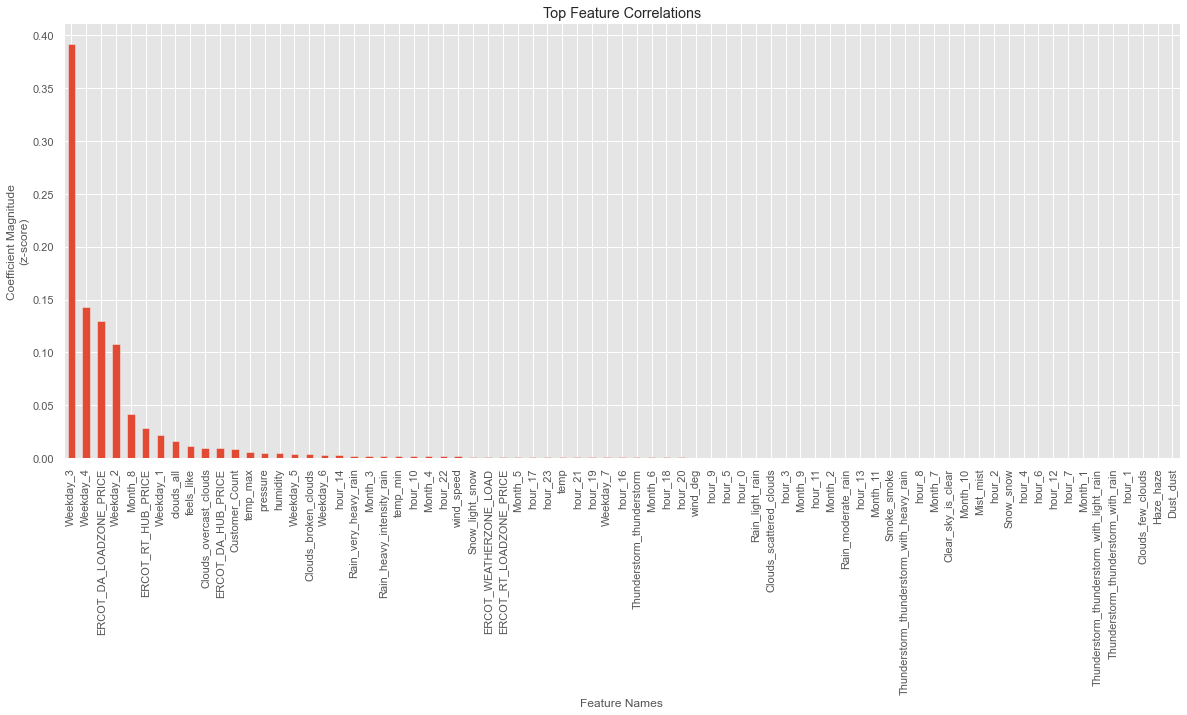

In [333]:
plt.style.use('ggplot')

wt_plt_df = ft_imp_df.head(75)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

In [335]:
X_train_valid, X_test_valid, y_train_valid, y_test_valid= train_test_split(X_scaled_valid, y_valid, test_size=0.2, shuffle=True, random_state=1)
XGB_model.fit(X_train_valid, y_train_valid, eval_metric='rmse')
y_hat=XGB_model.predict(X_test_valid)
RMSE = mean_squared_error(y_test_valid, y_hat, squared=False)
print('Validation RMSE=', RMSE)

Validation RMSE= 917.4356846368672


(0.0, 100.0)

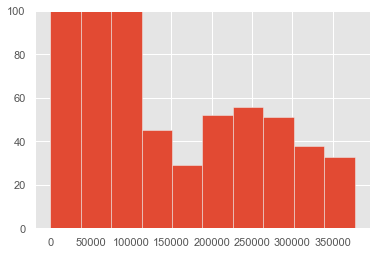

In [353]:
fig, ax = plt.subplots()
ax.hist(y)
ax.set_ylim(0,100)

(array([1.75519e+05, 1.71000e+02, 1.40000e+02, 4.50000e+01, 2.90000e+01,
        5.20000e+01, 5.60000e+01, 5.10000e+01, 3.80000e+01, 3.30000e+01]),
 array([     0. ,  37732.7,  75465.4, 113198.1, 150930.8, 188663.5,
        226396.2, 264128.9, 301861.6, 339594.3, 377327. ]),
 <BarContainer object of 10 artists>)

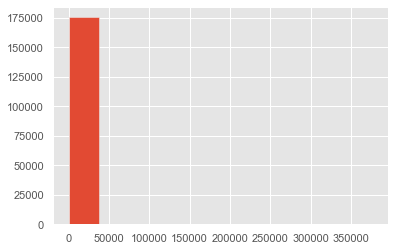

In [354]:
fig, ax = plt.subplots()
ax.hist(y)

In [55]:
#Now we will drop weather attributes or ecort price attribues to see if the model performace worse.
#We will choose XGBoost model as it performed the best.
X_price_only = X_scaled.drop(X_scaled.iloc[:,1:44],axis=1)
X_price_only.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176134 entries, 0 to 176133
Data columns (total 49 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Customer_Count           176134 non-null  float64
 1   ERCOT_WEATHERZONE_LOAD   176134 non-null  float64
 2   ERCOT_RT_LOADZONE_PRICE  176134 non-null  float64
 3   ERCOT_RT_HUB_PRICE       176134 non-null  float64
 4   ERCOT_DA_LOADZONE_PRICE  176134 non-null  float64
 5   ERCOT_DA_HUB_PRICE       176134 non-null  float64
 6   Weekday_1                176134 non-null  float64
 7   Weekday_2                176134 non-null  float64
 8   Weekday_3                176134 non-null  float64
 9   Weekday_4                176134 non-null  float64
 10  Weekday_5                176134 non-null  float64
 11  Weekday_6                176134 non-null  float64
 12  Weekday_7                176134 non-null  float64
 13  Month_1                  176134 non-null  float64
 14  Mont

In [56]:
X_weather_only = X_scaled.drop(X_scaled.iloc[:,45:49],axis=1)
X_weather_only.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176134 entries, 0 to 176133
Data columns (total 88 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   Customer_Count                                 176134 non-null  float64
 1   temp                                           176134 non-null  float64
 2   feels_like                                     176134 non-null  float64
 3   temp_min                                       176134 non-null  float64
 4   temp_max                                       176134 non-null  float64
 5   pressure                                       176134 non-null  float64
 6   humidity                                       176134 non-null  float64
 7   wind_speed                                     176134 non-null  float64
 8   wind_deg                                       176134 non-null  float64
 9   clouds_all                           

In [60]:
#Price only
XGB_model = XGBRegressor(objective='reg:squarederror',
                          booster='gbtree',
                          subsample=0.8,
                          random_state=1,
                          learning_rate=.1,
                          max_depth=16,
                          reg_alpha=50,
                          scale_pos_weight=5)
XGB_model.fit(X_price_only, y, eval_metric='rmse')
c1 = -cross_val_score(XGB_model, X_price_only, y, scoring='neg_root_mean_squared_error', cv=cv)
print('RMSE=',c1)
print('Average RMSE=', np.mean(c1))

RMSE= [2676.64949615 2860.14057153 2782.54187528 3570.16107128 2688.67500134]
Average RMSE= 2915.633603118873


In [61]:
#Weather only
XGB_model = XGBRegressor(objective='reg:squarederror',
                          booster='gbtree',
                          subsample=0.8,
                          random_state=1,
                          learning_rate=.1,
                          max_depth=16,
                          reg_alpha=50,
                          scale_pos_weight=5)
XGB_model.fit(X_weather_only, y, eval_metric='rmse')
c2 = -cross_val_score(XGB_model, X_weather_only,y, scoring='neg_root_mean_squared_error', cv=cv)
print('RMSE=',c2)
print('Average RMSE=', np.mean(c2))

RMSE= [4030.84026563 2837.70707783 2785.58972961 3140.43487989 2759.27058343]
Average RMSE= 3110.768507279731


#### We can tell both results yielded worse RMSE than before

In [181]:
#Use Validation set to validate the model we built.
#Fit the model by using modeling data
XGB_model.fit(X_scaled, y, eval_metric='rmse')
#Predict outage count by using validation data
y_hat=XGB_model.predict(X_scaled_valid)
RMSE = mean_squared_error(y_valid, y_hat, squared=False)
print('Validation RMSE=', RMSE)

Validation RMSE= 5938.432379799369


In [182]:
#Attach y_hat to original validation set
data_valid['outage_count_predict'] = y_hat

In [183]:
data_valid['outage_percent_predict'] = data_valid['outage_count_predict']/data_valid['Customer_Count']

In [184]:
#Assign the percentage to classification group. <1%, 1%-3%, 3%-10%, >10%.
data_valid['percentage_class'] = pd.cut(data_valid['outage_percent'], [0,.01,.03,.1,1], 4, labels = [0,1,2,3], 
                                        include_lowest=True)
data_valid['percentage_class'].value_counts()

0    139223
1       895
2       515
3       256
Name: percentage_class, dtype: int64

In [185]:
data_valid['percentage_class_predict'] = pd.cut(data_valid['outage_percent_predict'], [0,.01,.03,.1,1], 4, labels = [0,1,2,3], 
                                        include_lowest=True)
data_valid['percentage_class_predict'].value_counts()

0    126436
1      3028
2       696
3       409
Name: percentage_class_predict, dtype: int64

In [186]:
y_actual = pd.Series(data_valid['percentage_class'], name='Actual')
y_predict = pd.Series(data_valid['percentage_class_predict'], name='Predict')
df_confusion = pd.crosstab(y_actual, y_predict)
print(df_confusion)

Predict       0     1    2    3
Actual                         
0        125383  2849  648  144
1           727    73   32   11
2           318   104   16   50
3             8     2    0  204


In [187]:
#Use Micro F1. It is calculated by considering the total TP, total FP and total FN of the model. 
#It does not consider each class individually, It calculates the metrics globally. 
total_TP = df_confusion.iloc[0,0] + df_confusion.iloc[1,1] + df_confusion.iloc[2,2] + df_confusion.iloc[3,3]
total_FP_FN = df_confusion.iloc[0,1] + df_confusion.iloc[0,2] + df_confusion.iloc[0,3] + df_confusion.iloc[1,0]+ df_confusion.iloc[1,2] + df_confusion.iloc[1,3] + df_confusion.iloc[2,0] + df_confusion.iloc[2,1]+ df_confusion.iloc[2,3] + df_confusion.iloc[3,0] + df_confusion.iloc[3,1] + df_confusion.iloc[3,2]
        
Micro_F1 =total_TP/(total_FP_FN+total_TP)
print(Micro_F1)

0.9625255611975277


In [188]:
#Heavily weighted Class 0 makes the data extremely unbalanced. So in this case, we focus on class 3 which the
#outage percentage larger than 10%
#Let's take a look at class 3 individually.
TP_3 = df_confusion.iloc[3,3]
TN_3 = df_confusion.iloc[0,0] + df_confusion.iloc[0,1] + df_confusion.iloc[0,2] + df_confusion.iloc[1,0]+ df_confusion.iloc[1,1] + df_confusion.iloc[1,2] + df_confusion.iloc[2,0] + df_confusion.iloc[2,1]+ df_confusion.iloc[2,2]
FP_3 = df_confusion.iloc[0,3] + df_confusion.iloc[1,3] +df_confusion.iloc[2,3]
FN_3 = df_confusion.iloc[3,0] + df_confusion.iloc[3,1] +df_confusion.iloc[3,2]

In [189]:
precision_3 = TP_3/(TP_3+FP_3)
recall_3 = TP_3/(TP_3+ FN_3)
F1_score_3 = 2*TP_3/(2*TP_3+FP_3+FN_3)
print('Precision_3=', precision_3)
print('Recall_3=', recall_3)
print('F1_score_3=', F1_score_3)

Precision_3= 0.49877750611246946
Recall_3= 0.9532710280373832
F1_score_3= 0.6548956661316212


In [190]:
#Let's see how we can improve the prediction by using classification method by xgboost. 
#We now cut the outage percentage classifiction category ahead.
data_model['percentage_class'] = pd.cut(data_model['outage_percent'], [-1,.01,.03,.1,1], labels = [0,1,2,3], 
                                        include_lowest=True)
data_model['percentage_class'].value_counts()

0    173941
1      1292
2       498
3       401
Name: percentage_class, dtype: int64

In [197]:
X_class = data_model.drop(['Outage_Count','outage_percent','County', 'percentage_class'], axis=1).copy()
y_class = data_model['percentage_class'].copy()
X_class = pd.get_dummies(X_class,columns=['Weekday', 'Month','hour'])
X_scaled_class = scaler.fit_transform(X_class)
X_scaled_class = pd.DataFrame(data=X_scaled_class, columns=X_class.columns)

In [198]:
X_train_class, X_test_class, y_train_class, y_test_class= train_test_split(X_scaled_class, y_class, 
                                                                           test_size=0.2, shuffle=True, random_state=1)

In [199]:
#We have to use stratified K-fold to do cross-validation
cv_class=StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [195]:
#We really care Class 3 which outage percentage is larger than 10%
#So we set our probability to provide class 3
def my_roc_auc_score(model, X, y): 
    return roc_auc_score(y, model.predict_proba(X)[:,3])

In [196]:
largest_class_weight_coef = max(data_model['percentage_class'].value_counts().values)/data_model.shape[0]
largest_class_weight_coef

0.9875604660141257

In [228]:
#Now we have to deal with unbalanced class
def BalancedSampleWeights(y_train_class, largest_class_weight_coef):
    classes = y_train_class.unique()
    classes = classes.sort_values()
    class_samples = np.bincount(y_train_class)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[3]] = class_weight_dict[classes[3]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[classes[y]] for y in y_train_class]

    return sample_weights

In [229]:
sample_weight = BalancedSampleWeights(y_train_class, largest_class_weight_coef)

In [230]:
param_1 = {
    'reg_alpha': [200,100,50,10,1,.1,.01,.001],
    'learning_rate':[1,.1,.01]
}

In [231]:
optimal_1 = GridSearchCV(
   estimator=XGBClassifier(objective='multi:softprob',
                          booster='gbtree',
                          eval_metric='auc',
                          subsample=0.8,
                          random_state=1,
                          use_label_encoder=False),
     param_grid=param_1,
     scoring=my_roc_auc_score, 
     verbose=2,
     n_jobs =5,
     cv = cv_class)

optimal_1.fit(X_train_class, y_train_class, 
                early_stopping_rounds=10,
                sample_weight=sample_weight,
                eval_metric='auc',
                eval_set=[(X_test_class, y_test_class)],
                verbose=False)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='auc',
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_chi...
                                     objective='multi:softprob', random_state=1,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=0.8,
                                     tree_method=None, use_label_encoder=False,
               

In [232]:
print(optimal_1.best_params_)

{'learning_rate': 1, 'reg_alpha': 200}


In [233]:
conf = mt.confusion_matrix(y_test_class, optimal_1.predict(X_test_class))


print("confusion matrix\n",conf)

confusion matrix
 [[31731  2679   364    14]
 [   57   190    16     0]
 [    9    18    63     1]
 [    2     1     2    80]]


In [247]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_class, optimal_1.predict(X_test_class))))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_class, optimal_1.predict(X_test_class), average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_class, optimal_1.predict(X_test_class), average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_class, optimal_1.predict(X_test_class), average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_class, optimal_1.predict(X_test_class), average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_class, optimal_1.predict(X_test_class), average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_class, optimal_1.predict(X_test_class), average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_class, optimal_1.predict(X_test_class), average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_class, optimal_1.predict(X_test_class), average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_class, optimal_1.predict(X_test_class), average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_test_class, optimal_1.predict(X_test_class), target_names=['Class 0', 
                                                                                         'Class 1', 'Class 2', 'Class 3']))


Accuracy: 0.91

Micro Precision: 0.91
Micro Recall: 0.91
Micro F1-score: 0.91

Macro Precision: 0.51
Macro Recall: 0.82
Macro F1-score: 0.55

Weighted Precision: 0.99
Weighted Recall: 0.91
Weighted F1-score: 0.94

Classification Report

              precision    recall  f1-score   support

     Class 0       1.00      0.91      0.95     34788
     Class 1       0.07      0.72      0.12       263
     Class 2       0.14      0.69      0.24        91
     Class 3       0.84      0.94      0.89        85

    accuracy                           0.91     35227
   macro avg       0.51      0.82      0.55     35227
weighted avg       0.99      0.91      0.94     35227



In [294]:
XGB_class = XGBClassifier(objective='multi:softprob',
                          booster='gbtree',
                          eval_metric='auc',
                          subsample=0.8,
                          random_state=1,
                          use_label_encoder=False,
                          learning_rate=1,
                          reg_alpha=200)

XGB_class.fit(X_train_class, y_train_class, 
                early_stopping_rounds=10,
                sample_weight=sample_weight,
                eval_metric='auc',
                eval_set=[(X_train_class, y_train_class), (X_test_class, y_test_class)],
                verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', random_state=1,
              reg_alpha=200, reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [295]:
classificationSummary(y_test_class, XGB_class.predict(X_test_class), class_names=XGB_class.classes_)

Confusion Matrix (Accuracy 0.9102)

       Prediction
Actual     0     1     2     3
     0 31731  2679   364    14
     1    57   190    16     0
     2     9    18    63     1
     3     2     1     2    80


In [296]:
y_test_class_pred = XGB_class.predict_proba(X_test_class)

print("AUC test: {:.4f}".format(roc_auc_score(y_test_class, y_test_class_pred, multi_class='ovo', average='macro')))

AUC test: 0.9495


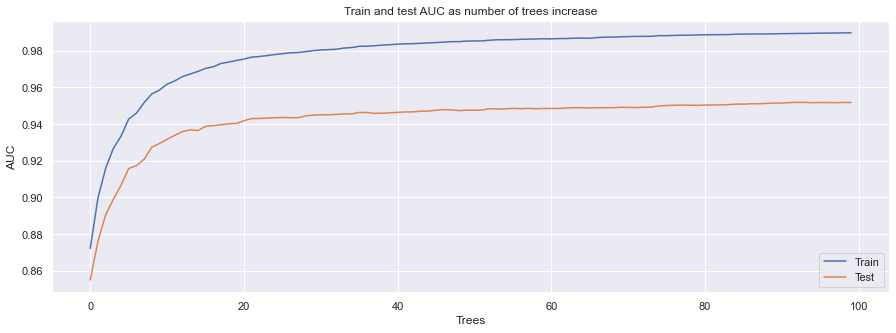

In [297]:
evaluation_results = XGB_class.evals_result()

train_auc_tree = evaluation_results['validation_0']['auc']
test_auc_tree = evaluation_results['validation_1']['auc']

plt.figure(figsize=(15,5))

plt.plot(train_auc_tree, label='Train')
plt.plot(test_auc_tree, label='Test')

plt.title("Train and test AUC as number of trees increase")
plt.xlabel("Trees")
plt.ylabel("AUC")
plt.legend(loc='lower right')
plt.show()

In [298]:
#Use the validation set to check the model performance. The model is still trained and fit by modeling set
X_class_valid = data_valid.drop(['Outage_Count','outage_percent','County', 'percentage_class',
                                'outage_count_predict','outage_percent_predict','percentage_class_predict'], axis=1).copy()
y_class_valid = data_valid['percentage_class'].copy()
X_class_valid = pd.get_dummies(X_class_valid,columns=['Weekday', 'Month','hour'])
X_scaled_class_valid = scaler.fit_transform(X_class_valid)
X_scaled_class_valid = pd.DataFrame(data=X_scaled_class_valid, columns=X_class_valid.columns)

In [299]:
classificationSummary(y_class_valid, XGB_class.predict(X_scaled_class_valid), class_names=XGB_class.classes_)

Confusion Matrix (Accuracy 0.9498)

       Prediction
Actual      0      1      2      3
     0 133317   4302   1578     26
     1    622    171     91     11
     2    268    122    106     19
     3      7      7     13    229


In [300]:
y_valid_class_pred = XGB_class.predict_proba(X_scaled_class_valid)

print("AUC test: {:.4f}".format(roc_auc_score(y_class_valid, y_valid_class_pred, multi_class='ovo', average='macro')))

AUC test: 0.8190


In [316]:
XGB_class.fit(X_train_class, y_train_class)
y_score = XGB_class.predict_proba(X_test_class)

In [321]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_class, y_score[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

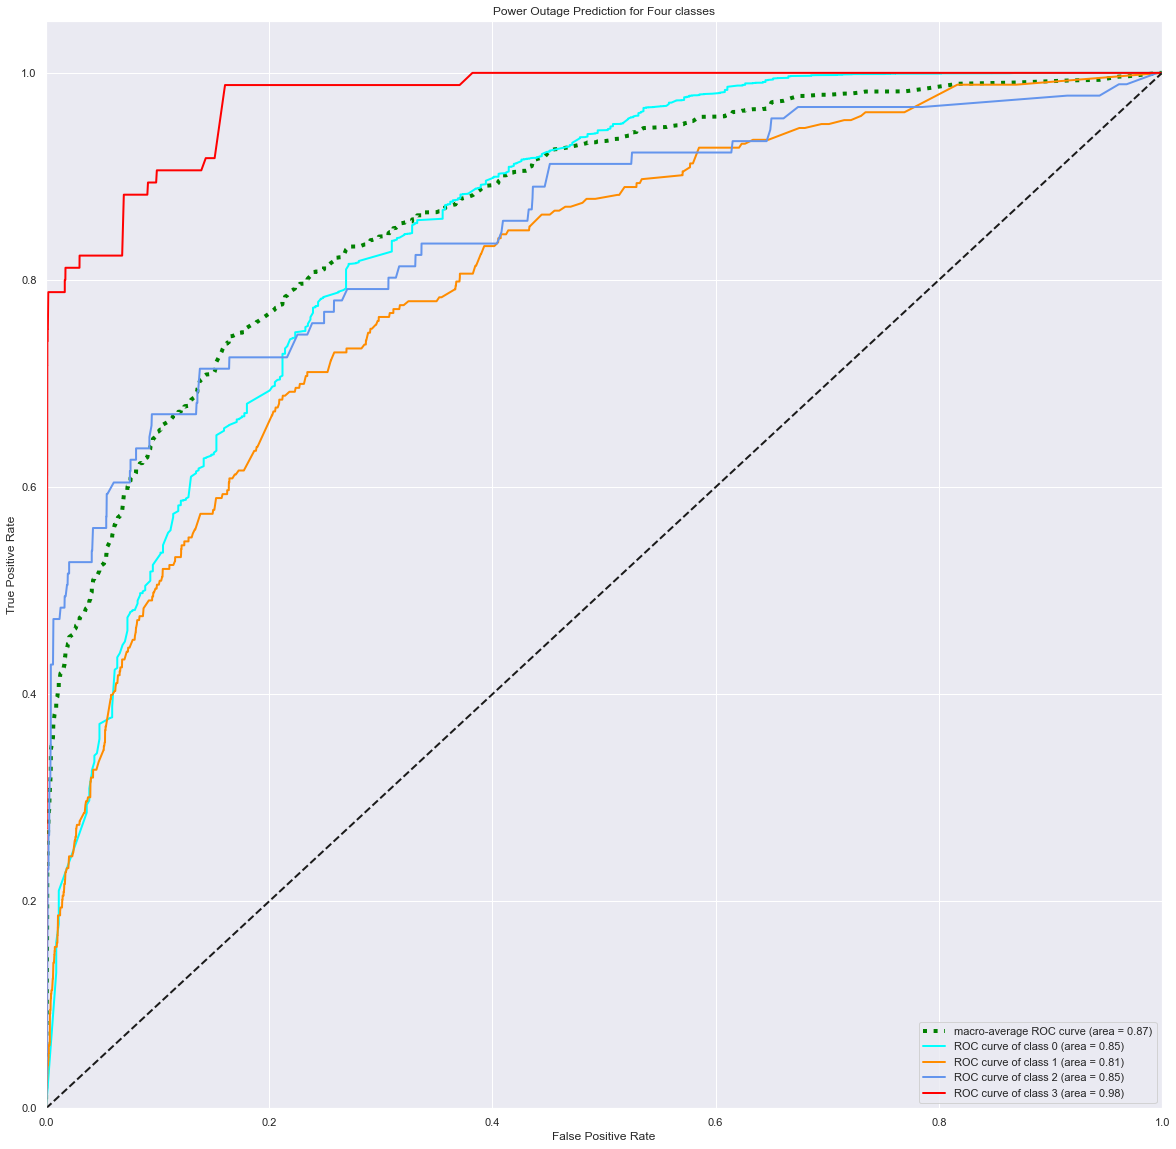

In [347]:
#Plot ROC curves
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="green",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "red"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Power Outage Prediction for Four classes")
plt.legend(loc="lower right")
plt.show()